# base setting

In [1131]:
# Google drive mout
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1132]:
# Library import
import pandas as pd

import numpy as np
from numpy import linalg

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import seaborn as sns

import math

from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import missingno as msno
import urllib
import re
import random

from datetime import datetime


import sympy
# Juypter 노트북에서 수학식의 LaTeX 표현을 위해 필요함
sympy.init_printing(use_latex='mathjax')


# from vega_datasets import data
# from tabulate import tabulate

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# plt.style.use('seaborn')
# plt.style.use('default')
# sns.set(font_scale=1)

# pandas loat format 설정
pd.options.display.float_format = '{:,.2f}'.format

In [1133]:
# 그래프 한글폰트 개선
# plt.rcParams['font.family'] ='Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] =False
# plt.rc('font', family='NanumGothic')

In [1134]:
# 그래프 한글폰트 개선
# !apt -qq -y install fonts-nanum > /dev/null
 
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=10)
# fm._rebuild()
 
# # 그래프에 retina display 적용
# %config InlineBackend.figure_format = 'retina'
 
# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 

# VGCartz



## 데이터 수집

- 데이터 출처
  - [VGChartz](https://www.vgchartz.com/)
    - [VGChartz](https://en.wikipedia.org/wiki/VGChartz)는 비디오게임 판매 추적 웹사이트
    - VGChartz는 데이터 소스를 제공하지 않기 때문에, 신뢰성에 의문이 제기되기도 함

- 데이터 수집방법
  - BeautifulSoup 를 이용한 웹스크랩핑
  - [VGChartz: GameDB: See All Games](https://www.vgchartz.com/gamedb/) 에서 데이터 수집
  1. Genre 리스트 웹스크랩핑
    - 'Action', 'Action-Adventure', 'Adventure', 'Board Game', 'Education', 'Fighting', 'Misc', 'MMO', 'Music', 'Party', 'Platform', 'Puzzle', 'Racing', 'Role-Playing', 'Sandbox', 'Shooter', 'Simulation', 'Sports', 'Strategy', 'Visual Novel'
  1. Genre 마다 페이지를 계산
    - 페이지 수 = 해당 장르 전체 게임 수 / 한페이지 출력 게임 수
  1. Genre 마다 페이지를 순회하며 데이터 스크래핑
    
- 최종 수집 된 데이터
  - 스크래핑일시 : 2023-01-04 02:05:26
  - row : 62434, column : 14


- 컬럼 설명  

|컬럼|내용|
|---|---|
|Genre|게임의 장르|
|Name|게임의 이름|
|url|게임 url|
|Platform|게임이 지원되는 플랫폼의 이름|
|Publisher|게임을 배급한 회사|
|VGC_Score|VGC 점수|
|Critic_Score|전문가 점수|
|User_Score|사용자 점수|
|Total_Sales|전체지역에서의 판매량 합계|
|NA_Sales|북미지역에서의 판매량|
|PAL_Sales|PAL지역*에서의 판매량|
|JP_Sales|일본지역에서의 판매량|
|Other_Sales|기타지역에서의 판매량|
|Year|게임이 출시된 연도|

\* [PAL 지역](https://ko.wikipedia.org/wiki/PAL_%EC%A7%80%EC%97%AD)(PAL region) 은 아시아, 아프리카, 유럽, 남아메리카, 오세아니아 대부분에 해당하는 텔레비전 방송 영토이다. 전통적으로 해당 지역에 사용되는 [PAL](https://ko.wikipedia.org/wiki/PAL)(Phase Alternating Line) 텔레비전 표준이기 때문에 그렇게 이름이 불린다. 이는 한국, 일본 및 북아메리카 지역 거의 대부분에서 사용되는 NTSC 표준과 대비된다.

<center>
<img alt="image" 
width=80% 
src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/PAL-NTSC-SECAM.svg/600px-PAL-NTSC-SECAM.svg.png">  
</center>


In [1135]:
VGC_path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/data/vgchartz.csv'
df_raw = pd.read_csv(VGC_path) # read
print(df_raw.shape)            # shape
df_raw.head()                  # head()
# Unnamed: 0 컬럼은 불필요함

(62437, 15)


,Unnamed: 0,Genre,Name,url,Platform,Publisher,VGC_Score,Critic_Score,User_Score,Total_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
0,0,Action,God of War,https://www.vgchartz.com/game/226282/god-of-war/,Series,Sony Computer Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,22nd Mar 05
1,1,Action,Warriors,https://www.vgchartz.com/game/226375/warriors/,Series,KOEI,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,30th Jun 97
2,2,Action,Devil May Cry,https://www.vgchartz.com/game/226043/devil-may...,Series,Capcom,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,16th Oct 01
3,3,Action,God of War (2018),https://www.vgchartz.com/game/230391/god-of-wa...,All,Sony Interactive Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,20th Apr 18
4,4,Action,Dynasty Warriors,https://www.vgchartz.com/game/226374/dynasty-w...,Series,KOEI,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,30th Jun 97


## EDA




In [1136]:
df_raw.columns

Index(['Unnamed: 0', 'Genre', 'Name', 'url', 'Platform', 'Publisher',
       'VGC_Score', 'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales',
       'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Year'],
      dtype='object')

In [1137]:
# 불필요한 컬럼 제거
df_raw.drop(columns=['Unnamed: 0'], inplace=True)
df_raw.columns

Index(['Genre', 'Name', 'url', 'Platform', 'Publisher', 'VGC_Score',
       'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales', 'PAL_Sales',
       'JP_Sales', 'Other_Sales', 'Year'],
      dtype='object')

### Name

In [1138]:
col = df_raw.Name
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Name 컬럼 정보
- 데이터타입        : object
- shape             : (62437,)
- 결측치 갯수       : 0
- 중복값 갯수       : 22946
- 유니크값 갯수     : 39491



In [1139]:
# 좌우공백제거
df_raw.Name = df_raw.Name.str.strip()

In [1140]:
# 중복값 보기
Name_count = pd.DataFrame(df_raw.Name.value_counts())
filt_p = Name_count.Name != 1
Name_count[filt_p]

,Name
Plants vs. Zombies,19
Monopoly,15
Doom,14
Elite,14
Double Dragon,14
...,...
60 Seconds!,2
Heart of the Woods,2
"Second Novel: Kanojo no Natsu, 15-Bun no Kioku",2
Root Film,2


In [1141]:
# Plants vs. Zombies 이 왜 중복된 데이터가 많은지 확인
df_raw[df_raw.Name == 'Plants vs. Zombies']

,Genre,Name,url,Platform,Publisher,VGC_Score,Critic_Score,User_Score,Total_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
25079,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/70589/plants-vs-...,PSV,Sony Computer Entertainment,8.0,N/A,N/A,NaN,NaN,NaN,NaN,NaN,21st Feb 12
25080,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72058/plants-vs-...,PS3,Sony Computer Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,08th Feb 11
25081,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72059/plants-vs-...,DS,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,18th Jan 11
25082,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72060/plants-vs-...,OSX,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,05th Mar 09
25083,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72062/plants-vs-...,And,Electronic Arts,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,14th Dec 11
25084,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72064/plants-vs-...,X360,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,08th Sep 10
25085,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72066/plants-vs-...,DSi,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,14th Mar 11
25086,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72069/plants-vs-...,And,Electronic Arts,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,14th Dec 11
25087,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72070/plants-vs-...,OSX,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,05th May 09
25088,Misc,Plants vs. Zombies,https://www.vgchartz.com/game/72071/plants-vs-...,WinP,PopCap Games,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,22nd Jun 11


### Platform

In [1142]:
col = df_raw.Platform
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Platform 컬럼 정보
- 데이터타입        : object
- shape             : (62437,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62357
- 유니크값 갯수     : 80



In [1143]:
df_raw.Platform.unique()

array(['Series', 'All', 'PS3', 'PS4', 'PS2', 'X360', 'PC', 'XOne', 'PS',
       'PSP', 'Wii', 'DS', '3DS', '2600', 'NS', 'iOS', 'NES', 'GC',
       'WiiU', 'XB', 'N64', 'GEN', 'GBA', 'GB', 'PSV', 'SNES', 'DC',
       'SAT', 'XBL', 'PSN', '5200', 'OSX', 'And', 'DSiW', 'Lynx', 'SCD',
       'Linux', 'MS', 'WW', 'ZXS', 'ACPC', 'Amig', '7800', 'VC', 'GG',
       'DSi', 'PCE', 'AJ', 'WinP', 'Mob', 'iQue', 'WS', 'NG', 'GIZ',
       '3DO', 'VB', 'GBC', 'Ouya', 'NGage', 'AST', 'MSD', 'S32X', 'PCFX',
       'XS', 'PS5', 'Int', 'CV', 'Arc', 'OR', 'CDi', 'C128', 'CD32',
       'C64', 'BRW', 'FMT', 'MSX', 'ApII', 'Aco', 'BBCM', 'TG16'],
      dtype=object)

##### 플랫폼 데이터프레임만들기

In [1144]:
# 웹스크래핑으로 만든 플랫폼 리스트1 불러오기
console_list1_path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/data/console_list.csv'
console_list1 = pd.read_csv(console_list1_path)                 # 데이터 읽기

console_list1.drop(columns=['Unnamed: 0'], inplace=True)        # Unnamed: 0 컬럼 제거
console_list1.rename(columns={'0': 'pf_name'}, inplace=True)    # 컬럼 이름 변경
console_list1['pf_name'] = console_list1['pf_name'].str.strip() # 공백 제거

print(console_list1.shape)
console_list1

(90, 1)


,pf_name
0,3DO Interactive Multiplayer
1,Acorn Electron
2,All
3,Amiga
4,Amiga CD32
...,...
85,Xbox 360
86,XBox Live
87,Xbox One
88,Xbox Series


In [1145]:
# 웹스크래핑으로 만든 플랫폼 리스트2 불러오기
console_list2_path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/data/console_list2.csv'
console_list2 = pd.read_csv(console_list2_path)                 # 데이터 읽기

console_list2.drop(columns=['Unnamed: 0'], inplace=True)        # Unnamed: 0 컬럼 제거
console_list2.rename(columns={'0' : 'pf_name'}, inplace=True)   # 컬럼 이름 변경
console_list2['pf_name'] = console_list2['pf_name'].str.strip() # 공백 제거

console_list2 = pd.DataFrame(console_list2['pf_name'].str.split('(', n=2, expand=True))
console_list2[1] = console_list2[1].str.slice(0,-1)
console_list2[0] = console_list2[0].str.strip()                 # 공백 제거
console_list2[1] = console_list2[1].str.strip()                 # 공백 제거
console_list2.rename(columns={0 : 'pf_name', 1 :'pf_nick'}, inplace=True) # 컬럼 이름 변경

print(console_list2.shape)
console_list2.head()

(51, 2)


,pf_name,pf_nick
0,PlayStation 2,PS2
1,Nintendo DS,DS
2,Nintendo Switch,NS
3,Game Boy,GB
4,PlayStation 4,PS4


In [1146]:
# 웹스크래핑으로 만든 플랫폼 리스트 합치기
console_list = pd.merge(left = console_list1, right = console_list2, how = 'left', on = 'pf_name')
console_list

,pf_name,pf_nick
0,3DO Interactive Multiplayer,3DO
1,Acorn Electron,NaN
2,All,NaN
3,Amiga,NaN
4,Amiga CD32,CD32
...,...,...
85,Xbox 360,X360
86,XBox Live,NaN
87,Xbox One,XOne
88,Xbox Series,NaN


In [1147]:
print(len(console_list.pf_nick.unique()))
console_list.pf_nick.unique()

46


array(['3DO', nan, 'CD32', '2600', '5200', '7800', 'AJ', 'Lynx', 'CDi',
       'CV', 'FCF', 'FDS', 'GB', 'GBA', 'GC', 'GG', 'GIZ', 'Int', 'Odys',
       'NGage', 'NG', '3DS', 'N64', 'DS', 'NES', 'NS', 'PCFX', 'PS',
       'PS2', 'PS3', 'PS4', 'PS5', 'PSP', 'PSV', 'S32X', 'SCD', 'GEN',
       'MS', 'SAT', 'SNES', 'TG16', 'VB', 'WS', 'XB', 'X360', 'XOne'],
      dtype=object)

###### 결측치 작업1

In [1148]:
console_list.isna().sum()

pf_name     0
pf_nick    45
dtype: int64

In [1149]:
isna_filt = console_list['pf_nick'].isna()

In [1150]:
console_list.loc[isna_filt].iloc[:10]

,pf_name,pf_nick
1,Acorn Electron,NaN
2,All,NaN
3,Amiga,NaN
5,Amstrad CPC,NaN
6,Android,NaN
7,Apple II,NaN
8,Arcade,NaN
14,Atari ST,NaN
15,BBC Micro,NaN
16,Browser,NaN


In [1151]:
column = 'pf_nick'

index = console_list.query('pf_name == "Acorn Electron"').index
console_list.loc[index, column] = 'Aco'

index = console_list.query('pf_name == "All"').index
console_list.loc[index, column] = 'All'

index = console_list.query('pf_name == "Amiga"').index
console_list.loc[index, column] = 'Amig'

index = console_list.query('pf_name == "Amstrad CPC"').index
console_list.loc[index, column] = 'ACPC'

index = console_list.query('pf_name == "Android"').index
console_list.loc[index, column] = 'And'

index = console_list.query('pf_name == "Apple II"').index
console_list.loc[index, column] = 'ApII'

index = console_list.query('pf_name == "Arcade"').index
console_list.loc[index, column] = 'Arc'

index = console_list.query('pf_name == "Atari ST"').index
console_list.loc[index, column] = 'AST'

index = console_list.query('pf_name == "BBC Micro"').index
console_list.loc[index, column] = 'BBCM'

index = console_list.query('pf_name == "Browser"').index
console_list.loc[index, column] = 'BRW'

index = console_list.query('pf_name == "Browser"').index
console_list.loc[index, column] = 'BRW'

index = console_list.query('pf_name == "Commodore 128"').index
console_list.loc[index, column] = 'C128'

index = console_list.query('pf_name == "Commodore 64"').index
console_list.loc[index, column] = 'C64'

index = console_list.query('pf_name == "DSi Ware"').index
console_list.loc[index, column] = 'DSiW'

index = console_list.query('pf_name == "FM Towns"').index
console_list.loc[index, column] = 'FMT'

index = console_list.query('pf_name == "Game Boy Color"').index
console_list.loc[index, column] = 'GBC'

index = console_list.query('pf_name == "iOS"').index
console_list.loc[index, column] = 'iOS'

index = console_list.query('pf_name == "iQue"').index
console_list.loc[index, column] = 'iQue'

index = console_list.query('pf_name == "Linux"').index
console_list.loc[index, column] = 'Linux'

index = console_list.query('pf_name == "Mac OS X"').index
console_list.loc[index, column] = 'OSX'

index = console_list.query('pf_name == "MS-DOS"').index
console_list.loc[index, column] = 'MSD'

index = console_list.query('pf_name == "MSX"').index
console_list.loc[index, column] = 'MSX'

index = console_list.query('pf_name == "Oculus Rift"').index
console_list.loc[index, column] = 'OR'

index = console_list.query('pf_name == "Nintendo DSi"').index
console_list.loc[index, column] = 'DSi'

index = console_list.query('pf_name == "Ouya"').index
console_list.loc[index, column] = 'Ouya'

index = console_list.query('pf_name == "PCE"').index
console_list.loc[index, column] = 'PCE'

index = console_list.query('pf_name == "PlayStation Network"').index
console_list.loc[index, column] = 'PSN'

index = console_list.query('pf_name == "Sega Dreamcast"').index
console_list.loc[index, column] = 'DC'

index = console_list.query('pf_name == "Series"').index
console_list.loc[index, column] = 'Series'

index = console_list.query('pf_name == "Standard Mobile"').index
console_list.loc[index, column] = 'Mob'

index = console_list.query('pf_name == "Virtual Console"').index
console_list.loc[index, column] = 'VC'

index = console_list.query('pf_name == "Wii"').index
console_list.loc[index, column] = 'Wii'

index = console_list.query('pf_name == "Wii U"').index
console_list.loc[index, column] = 'WiiU'

index = console_list.query('pf_name == "WiiWare"').index
console_list.loc[index, column] = 'WW'

index = console_list.query('pf_name == "Windows Phone"').index
console_list.loc[index, column] = 'WinP'

index = console_list.query('pf_name == "XBox Live"').index
console_list.loc[index, column] = 'XBL'

index = console_list.query('pf_name == "Xbox Series"').index
console_list.loc[index, column] = 'XS'

index = console_list.query('pf_name == "ZX Spectrum"').index
console_list.loc[index, column] = 'ZXS'

###### 결측치 작업2

In [1152]:
console_list.isna().sum()

pf_name    0
pf_nick    8
dtype: int64

In [1153]:
isna_filt = console_list['pf_nick'].isna()
console_list.loc[isna_filt]
# 해당 플랫폼들은 데이터가 없기 때문에 제거

,pf_name,pf_nick
31,HTC Vive,NaN
38,Microsoft Windows,NaN
43,Neo Geo X,NaN
44,Nintendo 2DS,NaN
51,Nvidia Shield,NaN
64,Playstation VR,NaN
73,Super Famicom,NaN
76,Unknown,NaN


In [1154]:
console_list = console_list.drop(index=console_list.loc[isna_filt].index) # 비어있는 플랫폼
console_list = console_list.sort_values('pf_name')                        # 정렬
console_list = console_list.reset_index(drop=True)                        # 인덱스 재지정

print('💚 console_list 결측치 💚\n', console_list.isna().sum(), '\n')
print('💚 console_list shape 💚\n', console_list.shape, '\n')
console_list

💚 console_list 결측치 💚
 pf_name    0
pf_nick    0
dtype: int64 

💚 console_list shape 💚
 (82, 2) 



,pf_name,pf_nick
0,3DO Interactive Multiplayer,3DO
1,Acorn Electron,Aco
2,All,All
3,Amiga,Amig
4,Amiga CD32,CD32
...,...,...
77,Xbox One,XOne
78,Xbox Series,XS
79,ZX Spectrum,ZXS
80,iOS,iOS


##### 플랫폼 데이터 비교

In [1155]:
isin_filt = console_list['pf_nick'].isin(df_raw.Platform)
console_list[~isin_filt]      # 빈 플랫폼은 삭제

,pf_name,pf_nick
23,Fairchild Channel F,FCF
24,Famicom Disk System,FDS
36,Magnavox Odyssey,Odys


In [1156]:
console_list = console_list.drop(index=console_list[~isin_filt].index)
console_list = console_list.reset_index(drop=True) # 인덱스 재지정
isin_filt = console_list['pf_nick'].isin(df_raw.Platform)
console_list[~isin_filt] # 빈 플랫폼 없음

,pf_name,pf_nick


In [1157]:
print(len(console_list['pf_nick'].unique()))
console_list['pf_nick'].unique()

79


array(['3DO', 'Aco', 'All', 'Amig', 'CD32', 'ACPC', 'And', 'ApII', 'Arc',
       '2600', '5200', '7800', 'AJ', 'Lynx', 'AST', 'BBCM', 'BRW', 'CDi',
       'CV', 'C128', 'C64', 'DSiW', 'FMT', 'GB', 'GBA', 'GBC', 'GC', 'GG',
       'GIZ', 'Int', 'Linux', 'MSD', 'MSX', 'OSX', 'NGage', 'NG', '3DS',
       'N64', 'DS', 'DSi', 'NES', 'NS', 'OR', 'Ouya', 'PCFX', 'PCE', 'PS',
       'PS2', 'PS3', 'PS4', 'PS5', 'PSN', 'PSP', 'PSV', 'S32X', 'SCD',
       'DC', 'GEN', 'MS', 'SAT', 'Series', 'Mob', 'SNES', 'TG16', 'VB',
       'VC', 'Wii', 'WiiU', 'WW', 'WinP', 'WS', 'XBL', 'XB', 'X360',
       'XOne', 'XS', 'ZXS', 'iOS', 'iQue'], dtype=object)

In [1158]:
plat_list = pd.DataFrame(df_raw.Platform.unique())
plat_list

,0
0,Series
1,All
2,PS3
3,PS4
4,PS2
...,...
75,MSX
76,ApII
77,Aco
78,BBCM


In [1159]:
isin_filt = console_list['pf_nick'].isin(plat_list[0])
console_list[~isin_filt]

,pf_name,pf_nick


In [1160]:
print(len(df_raw.Platform.value_counts().sort_index().index))
df_raw.Platform.value_counts().sort_index().index

80


Index(['2600', '3DO', '3DS', '5200', '7800', 'ACPC', 'AJ', 'AST', 'Aco', 'All',
       'Amig', 'And', 'ApII', 'Arc', 'BBCM', 'BRW', 'C128', 'C64', 'CD32',
       'CDi', 'CV', 'DC', 'DS', 'DSi', 'DSiW', 'FMT', 'GB', 'GBA', 'GBC', 'GC',
       'GEN', 'GG', 'GIZ', 'Int', 'Linux', 'Lynx', 'MS', 'MSD', 'MSX', 'Mob',
       'N64', 'NES', 'NG', 'NGage', 'NS', 'OR', 'OSX', 'Ouya', 'PC', 'PCE',
       'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSN', 'PSP', 'PSV', 'S32X',
       'SAT', 'SCD', 'SNES', 'Series', 'TG16', 'VB', 'VC', 'WS', 'WW', 'Wii',
       'WiiU', 'WinP', 'X360', 'XB', 'XBL', 'XOne', 'XS', 'ZXS', 'iOS',
       'iQue'],
      dtype='object')

In [1161]:
print(len(console_list['pf_nick'].unique()))
console_list['pf_nick'].unique()

79


array(['3DO', 'Aco', 'All', 'Amig', 'CD32', 'ACPC', 'And', 'ApII', 'Arc',
       '2600', '5200', '7800', 'AJ', 'Lynx', 'AST', 'BBCM', 'BRW', 'CDi',
       'CV', 'C128', 'C64', 'DSiW', 'FMT', 'GB', 'GBA', 'GBC', 'GC', 'GG',
       'GIZ', 'Int', 'Linux', 'MSD', 'MSX', 'OSX', 'NGage', 'NG', '3DS',
       'N64', 'DS', 'DSi', 'NES', 'NS', 'OR', 'Ouya', 'PCFX', 'PCE', 'PS',
       'PS2', 'PS3', 'PS4', 'PS5', 'PSN', 'PSP', 'PSV', 'S32X', 'SCD',
       'DC', 'GEN', 'MS', 'SAT', 'Series', 'Mob', 'SNES', 'TG16', 'VB',
       'VC', 'Wii', 'WiiU', 'WW', 'WinP', 'WS', 'XBL', 'XB', 'X360',
       'XOne', 'XS', 'ZXS', 'iOS', 'iQue'], dtype=object)

In [1162]:
isin_filt = plat_list[0].isin(console_list['pf_nick'])
plat_list[~isin_filt]

,0
6,PC


In [1163]:
# console_list 에 PC 추가하기
index = len(console_list)+1
console_list.loc[index] = [ 'PC Games', 'PC' ]

In [1164]:
console_list.tail()

,pf_name,pf_nick
75,Xbox Series,XS
76,ZX Spectrum,ZXS
77,iOS,iOS
78,iQue,iQue
80,PC Games,PC


In [1165]:
console_list = console_list.sort_values('pf_name') # 정렬
console_list = console_list.reset_index(drop=True) # 인덱스 재지정

print('💚 console_list 결측치 💚\n', console_list.isna().sum(), '\n')
print('💚 console_list shape 💚\n', console_list.shape, '\n')
console_list

💚 console_list 결측치 💚
 pf_name    0
pf_nick    0
dtype: int64 

💚 console_list shape 💚
 (80, 2) 



,pf_name,pf_nick
0,3DO Interactive Multiplayer,3DO
1,Acorn Electron,Aco
2,All,All
3,Amiga,Amig
4,Amiga CD32,CD32
...,...,...
75,Xbox One,XOne
76,Xbox Series,XS
77,ZX Spectrum,ZXS
78,iOS,iOS


##### 플랫폼 세대분류
- [Home video game console generations](https://en.wikipedia.org/wiki/Home_video_game_console_generations)

<center>
<img alt="image" 
width=90% 
src="https://upload.wikimedia.org/wikipedia/en/timeline/dvi8hgniehwes0vxhfxxuhflggelxtl.png">  
</center>

In [1166]:
# 엑셀저장
console_list_xlsx_save_path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/data/console_list_work.xlsx'
# console_list.to_excel(console_list_xlsx_save_path)

In [1167]:
console_list.pf_name.unique()

array(['3DO Interactive Multiplayer', 'Acorn Electron', 'All', 'Amiga',
       'Amiga CD32', 'Amstrad CPC', 'Android', 'Apple II', 'Arcade',
       'Atari 2600', 'Atari 5200', 'Atari 7800', 'Atari Jaguar',
       'Atari Lynx', 'Atari ST', 'BBC Micro', 'Browser', 'CD-i',
       'ColecoVision', 'Commodore 128', 'Commodore 64', 'DSi Ware',
       'FM Towns', 'Game Boy', 'Game Boy Advance', 'Game Boy Color',
       'GameCube', 'GameGear', 'Gizmondo', 'Intellivision', 'Linux',
       'MS-DOS', 'MSX', 'Mac OS X', 'N-Gage', 'Neo Geo', 'Nintendo 3DS',
       'Nintendo 64', 'Nintendo DS', 'Nintendo DSi',
       'Nintendo Entertainment System', 'Nintendo Switch', 'Oculus Rift',
       'Ouya', 'PC Games', 'PC-FX', 'PCE', 'PlayStation', 'PlayStation 2',
       'PlayStation 3', 'PlayStation 4', 'PlayStation 5',
       'PlayStation Network', 'PlayStation Portable', 'PlayStation Vita',
       'Sega 32X', 'Sega CD', 'Sega Dreamcast', 'Sega Genesis',
       'Sega Master System', 'Sega Saturn', 'Series'

In [1168]:
console_list.pf_nick.unique()

array(['3DO', 'Aco', 'All', 'Amig', 'CD32', 'ACPC', 'And', 'ApII', 'Arc',
       '2600', '5200', '7800', 'AJ', 'Lynx', 'AST', 'BBCM', 'BRW', 'CDi',
       'CV', 'C128', 'C64', 'DSiW', 'FMT', 'GB', 'GBA', 'GBC', 'GC', 'GG',
       'GIZ', 'Int', 'Linux', 'MSD', 'MSX', 'OSX', 'NGage', 'NG', '3DS',
       'N64', 'DS', 'DSi', 'NES', 'NS', 'OR', 'Ouya', 'PC', 'PCFX', 'PCE',
       'PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSN', 'PSP', 'PSV', 'S32X',
       'SCD', 'DC', 'GEN', 'MS', 'SAT', 'Series', 'Mob', 'SNES', 'TG16',
       'VB', 'VC', 'Wii', 'WiiU', 'WW', 'WinP', 'WS', 'XBL', 'XB', 'X360',
       'XOne', 'XS', 'ZXS', 'iOS', 'iQue'], dtype=object)

In [1169]:
pf_gens = [5, 2, 8, 2, 5, 2, 8, 1, 1, 2, 
        2, 3, 5, 4, 2, 3, 7, 4, 2, 3, 
        2, 9, 5, 5, 6, 6, 6, 5, 6, 2, 
        8, 3, 2, 8, 6, 4, 7, 5, 6, 6, 
        3, 8, 9, 8, 8, 5, 3, 5, 6, 7, 
        8, 9, 7, 7, 7, 5, 4, 6, 4, 3, 
        4, 0, 8, 4, 4, 7, 7, 7, 8, 7, 
        8, 5, 6, 6, 7, 8, 9, 2, 8, 6]

In [1170]:
pf_manufacturer = ['Panasonic', 'Acorn', 'Unknown', 'Commodore', 'Commodore', 'Amstrad', 'Unknown', 'Apple', 'Unknown', 'Atari', 
                'Atari', 'Atari', 'Atari', 'Atari', 'Atari', 'Acorn', 'Unknown', 'Sony', 'Coleco', 'Commodore', 
                'Commodore', 'Nintendo', 'Fujitsu', 'Nintendo', 'Nintendo', 'Nintendo', 'Nintendo', 'Sega', 'Tiger Telematics', 'Mattel Electronics', 
                'Unknown', 'Unknown', 'ASCII', 'Unknown', 'Nokia', 'Neo Geo', 'Nintendo', 'Nintendo', 'Nintendo', 'Nintendo', 
                'Nintendo', 'Nintendo', 'Oculus', 'Ouya', 'Unknown', 'NEC', 'NEC', 'Sony', 'Sony', 'Sony', 
                'Sony', 'Sony', 'Sony', 'Sony', 'Sony', 'Sega', 'Sega', 'Sega', 'Sega', 'Sega', 
                'Sega', 'Unknown', 'Unknown', 'Nintendo', 'NEC', 'Nintendo', 'Nintendo', 'Nintendo', 'Nintendo', 'Nintendo', 
                'Microsoft', 'Bandai', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Sinclair', '-', 'iQue']

In [1171]:
pf_release = ['1993', '1983', '-', '1985', '1993', '1984', '-', '1977', '-', '1977', 
              '1982', '1986', '1993', '1989', '1985', '1981', '-', '1990', '1982', '1985', 
              '1982', '2010', '1989', '1989', '2001', '1998', '2001', '1990', '2005', '1979 ', 
              '-', '-', '1983 ', '-', '2003', '1990', '2011', '1996', '2004', '2008', 
              '1983 ', '2017', '2012', '2013', '-', '1994', '1987', '1994', '2000', '2006 ', 
              '2013', '2020', '2006', '2004', '2011', '1994', '1991', '1998', '1988', '1985 ', 
              '1994', '-', '-', '1990', '1987', '1995', '2006', '2006', '2012', '2012', 
              '2010', '1999', '2002', '2001', '2005', '2013', '2020', '1982', '-', '2002']

In [1172]:
pf_type = ['video game console', 'computer', 'computer', 'computer', 'video game console', 'computer', 'mobile', 'computer', 'computer', 'video game console', 
           'video game console', 'video game console', 'video game console', 'Handheld', 'computer', 'computer', 'computer', 'video game console', 'video game console', 'computer', 
           'computer', 'Virtual Reality', 'video game console', 'Handheld', 'Handheld', 'Handheld', 'video game console', 'Handheld', 'Handheld', 'video game console', 
           'computer', 'computer', 'computer', 'computer', 'Handheld', 'video game console', 'Handheld', 'video game console', 'Handheld', 'Handheld', 
           'video game console', 'Handheld', 'Virtual Reality', 'video game console', 'computer', 'video game console', 'video game console', 'video game console', 'video game console', 'video game console', 
           'video game console', 'video game console', 'Online service', 'Handheld', 'Handheld', 'video game console', 'video game console', 'video game console', 'video game console', 'video game console', 
           'video game console', 'computer', 'mobile', 'video game console', 'video game console', 'Virtual Reality', 'Virtual Reality', 'video game console', 'Handheld', 'Virtual Reality', 
           'mobile', 'Handheld', 'Online service', 'video game console', 'video game console', 'video game console', 'video game console', 'computer', 'mobile', 'video game console']

In [1173]:
console_list['pf_gens'] = pf_gens
console_list['pf_manufacturer'] = pf_manufacturer
console_list['pf_release'] = pf_release
console_list['pf_type'] = pf_type

In [1174]:
console_list.pf_release.replace('-', '9999', inplace=True)
console_list.pf_release = console_list.pf_release.astype(int)

##### 기존 데이터프레임에 플랫폼 정보 merge

In [1175]:
df_raw.head()

,Genre,Name,url,Platform,Publisher,VGC_Score,Critic_Score,User_Score,Total_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
0,Action,God of War,https://www.vgchartz.com/game/226282/god-of-war/,Series,Sony Computer Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,22nd Mar 05
1,Action,Warriors,https://www.vgchartz.com/game/226375/warriors/,Series,KOEI,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,30th Jun 97
2,Action,Devil May Cry,https://www.vgchartz.com/game/226043/devil-may...,Series,Capcom,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,16th Oct 01
3,Action,God of War (2018),https://www.vgchartz.com/game/230391/god-of-wa...,All,Sony Interactive Entertainment,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,20th Apr 18
4,Action,Dynasty Warriors,https://www.vgchartz.com/game/226374/dynasty-w...,Series,KOEI,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,30th Jun 97


In [1176]:
console_list.rename(columns={'pf_nick': 'Platform'}, inplace=True) # 컬럼 이름 변경

In [1177]:
console_list.head()

,pf_name,Platform,pf_gens,pf_manufacturer,pf_release,pf_type
0,3DO Interactive Multiplayer,3DO,5,Panasonic,1993,video game console
1,Acorn Electron,Aco,2,Acorn,1983,computer
2,All,All,8,Unknown,9999,computer
3,Amiga,Amig,2,Commodore,1985,computer
4,Amiga CD32,CD32,5,Commodore,1993,video game console


In [1178]:
df_raw = pd.merge(left = df_raw, right = console_list, how = 'left', on = 'Platform')

##### 플랫폼 범주화

In [1179]:
# 플랫폼 7 범주화
pc_7 = ['PC', 'OSX', 'Series', 'Linux', 'BRW', 'MSD', 'ACPC', 'MSX', 'ApII', 'All']
mobile_7 = ['And', 'iOS', 'WinP', 'Mob']
console_7 = ['PS2', 'PS', 'PS4', 'PS3', 'XOne', 'X360', 'Wii', 'SNES', 'NES', 'XB', 'GEN', 'SAT', 'VC', 'GC', 'DC', 
           '2600', 'PCE', 'XS', 'PS5', 'N64', 'MS', '3DO', 'SCD', 'NG', 'Int', 'DSi', 'AJ', '5200', 'PCFX', '7800', 'CV', 'C64', 
           'Amig', 'Ouya', 'ZXS', 'AST', 'iQue', 'CDi', 'S32X', 'CD32', 'FMT', 'TG16', 'C128', 'Aco', 'BBCM']
portable_7 = ['DS', 'NS', 'PSP', 'GBA', 'GB', '3DS', 'PSV', 'WiiU', 'GG', 'WS', 'Lynx', 'NGage', 'GIZ', 'GBC', ]
arcade_7 = ['Arc']
network_7 = ['XBL', 'PSN']
vr_7 = ['OR', 'VB', 'DSiW', 'WW']

In [1180]:
df_raw['Platform_7'] = 'pc'
df_raw.loc[df_raw[df_raw.Platform.isin(mobile_7)].index, 'Platform_7'] = 'mobile'
df_raw.loc[df_raw[df_raw.Platform.isin(console_7)].index, 'Platform_7'] = 'console'
df_raw.loc[df_raw[df_raw.Platform.isin(portable_7)].index, 'Platform_7'] = 'portable'
df_raw.loc[df_raw[df_raw.Platform.isin(arcade_7)].index, 'Platform_7'] = 'arcade'
df_raw.loc[df_raw[df_raw.Platform.isin(network_7)].index, 'Platform_7'] = 'network'
df_raw.loc[df_raw[df_raw.Platform.isin(vr_7)].index, 'Platform_7'] = 'vr'

In [1181]:
print('Platform_7 결측치 : ', df_raw['Platform_7'].isna().sum(), '\n')
df_raw['Platform_7'].value_counts()

Platform_7 결측치 :  0 



console     26707
pc          14916
portable    14082
network      4126
mobile       1282
vr           1272
arcade         52
Name: Platform_7, dtype: int64

In [1182]:
# 플랫폼 3 범주화
pc_3 = ['PC', 'OSX', 'Series', 'Linux', 'BRW', 'MSD', 'ACPC', 'MSX', 'ApII', 'All']
console_3 = ['PS2', 'PS', 'PS4', 'PS3', 'XOne', 'X360', 'Wii', 'SNES', 'NES', 'XB', 'GEN', 'SAT', 'VC', 'GC', 'DC', 'XBL', 'PSN', 'Arc',
           '2600', 'PCE', 'XS', 'PS5', 'N64', 'MS', '3DO', 'SCD', 'NG', 'Int', 'DSi', 'AJ', '5200', 'PCFX', '7800', 'CV', 'C64', 
           'Amig', 'Ouya', 'ZXS', 'AST', 'iQue', 'CDi', 'S32X', 'CD32', 'FMT', 'TG16', 'C128', 'Aco', 'BBCM', 'OR', 'VB', 'DSiW', 'WW']
portable_3 = ['DS', 'NS', 'PSP', 'GBA', 'GB', '3DS', 'PSV', 'WiiU', 'GG', 'WS', 'Lynx', 'NGage', 'GIZ', 'GBC', 'And', 'iOS', 'WinP', 'Mob']

In [1183]:
df_raw['Platform_3'] = 'pc'
df_raw.loc[df_raw[df_raw.Platform.isin(console_3)].index, 'Platform_3'] = 'console'
df_raw.loc[df_raw[df_raw.Platform.isin(portable_3)].index, 'Platform_3'] = 'portable'

In [1184]:
print('Platform_3 결측치 : ', df_raw['Platform_3'].isna().sum(), '\n')
df_raw['Platform_3'].value_counts()

Platform_3 결측치 :  0 



console     32157
portable    15364
pc          14916
Name: Platform_3, dtype: int64

### Year

In [1185]:
col = df_raw.Year
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Year 컬럼 정보
- 데이터타입        : object
- shape             : (62437,)
- 결측치 갯수       : 0
- 중복값 갯수       : 54618
- 유니크값 갯수     : 7819



In [1186]:
# data 확인
df_raw.Year.value_counts()

N/A              5655
01st Jan 94       515
01st Jan 93       449
01st Jan 92       389
01st Jan 95       351
                 ... 
04th Oct 95         1
26th Jul 95         1
10th May 03         1
08th Nov 22         1
11th Aug 16         1
Name: Year, Length: 7819, dtype: int64

In [1187]:
df_raw.Year = df_raw.Year.str.strip()

In [1188]:
df_raw.Year = df_raw.Year.str.slice(-2,) 

In [1189]:
# 결측데이터 보기
df_raw.Year.isna().sum() # 결측치 없음

0

In [1190]:
df_raw.loc[df_raw[df_raw.Year == '/A'].index, 'Year'] = '9999'

In [1191]:
df_raw.Year.value_counts()

9999    5655
09      4357
10      3587
11      3390
08      2934
14      2895
07      2525
06      2095
05      1810
13      1740
02      1724
03      1720
15      1675
04      1600
12      1581
17      1557
00      1547
18      1530
01      1475
20      1454
16      1347
19      1289
99      1272
96      1224
94      1163
95      1148
98      1092
97      1036
93      1032
92       934
91       780
90       656
89       427
21       404
83       297
88       294
87       270
82       211
86       159
22       115
85       101
84        99
70        82
81        50
78        45
80        35
77        11
79         8
23         2
71         1
75         1
73         1
Name: Year, dtype: int64

In [1192]:
df_raw.Year = df_raw.Year.astype(int) # 데이터타입 정수형으로 변환
df_raw.Year.dtypes

dtype('int64')

In [1193]:
print(f"""\
출시년도가 40 이하인 케이스 수    : {df_raw.query('Year <= 40').shape[0]}
40 < 출시년도 <=99 케이스 수      : {df_raw.query('Year > 40 & Year <= 99').shape[0]}
""")

출시년도가 40 이하인 케이스 수    : 44353
40 < 출시년도 <=99 케이스 수      : 12429



In [1194]:
df_raw.columns

Index(['Genre', 'Name', 'url', 'Platform', 'Publisher', 'VGC_Score',
       'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales', 'PAL_Sales',
       'JP_Sales', 'Other_Sales', 'Year', 'pf_name', 'pf_gens',
       'pf_manufacturer', 'pf_release', 'pf_type', 'Platform_7', 'Platform_3'],
      dtype='object')

In [1195]:
filt_40 = df_raw.Year <= 40 # 출시년도가 40 이하인 케이스 필터링
df_raw[filt_40].index
df_raw.loc[df_raw[filt_40].index, 'Year'] = df_raw.loc[df_raw[filt_40].index, 'Year'] + 2000 # 기존값에 +2000
df_raw[filt_40].Year.value_counts() # 출시년도가 40 이하인 케이스 +2000 완료

2009    4357
2010    3587
2011    3390
2008    2934
2014    2895
2007    2525
2006    2095
2005    1810
2013    1740
2002    1724
2003    1720
2015    1675
2004    1600
2012    1581
2017    1557
2000    1547
2018    1530
2001    1475
2020    1454
2016    1347
2019    1289
2021     404
2022     115
2023       2
Name: Year, dtype: int64

In [1196]:
filt_99 = df_raw.Year <= 99 # 출시년도가 99 이하인 케이스 필터링
df_raw[filt_99].index
df_raw.loc[df_raw[filt_99].index, 'Year'] = df_raw.loc[df_raw[filt_99].index, 'Year'] + 1900 # 기존값에 +1900
df_raw[filt_99].Year.value_counts() # 출시년도가 30 이하인 케이스 +1900 완료

1999    1272
1996    1224
1994    1163
1995    1148
1998    1092
1997    1036
1993    1032
1992     934
1991     780
1990     656
1989     427
1983     297
1988     294
1987     270
1982     211
1986     159
1985     101
1984      99
1970      82
1981      50
1978      45
1980      35
1977      11
1979       8
1971       1
1975       1
1973       1
Name: Year, dtype: int64

In [1197]:
df_raw.Year.unique()

array([2005, 1997, 2001, 2018, 2013, 1981, 2014, 2004, 2016, 2002, 2015,
       2008, 2020, 2011, 1988, 2010, 2009, 1999, 2019, 1998, 2007, 2022,
       2006, 2000, 1996, 2017, 1982, 2003, 1985, 1989, 2012, 1990, 9999,
       1995, 2021, 1991, 1994, 1992, 1977, 1986, 1993, 1984, 1983, 1987,
       1978, 1979, 1970, 1980, 2023, 1971, 1975, 1973])

### Genre

In [1198]:
col = df_raw.Genre
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Genre 컬럼 정보
- 데이터타입        : object
- shape             : (62437,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62417
- 유니크값 갯수     : 20



##### 장르 : 범주 축소

- action = 'Action','Fighting','Shooter'
- rpg = 'MMO','Party','Role-Playing','Sandbox'
- adventure = 'Action-Adventure','Adventure','Platform','Visual Novel'
- simul = 'Simulation','Strategy'
- sports = 'Racing','Sports'
- misc = 'Board Game','Education','Misc','Music','Puzzle'

In [1199]:
action = ['Action','Fighting','Shooter']
rpg = ['MMO','Party','Role-Playing','Sandbox']
adventure = ['Action-Adventure','Adventure','Platform','Visual Novel']
simul = ['Simulation','Strategy']
sports = ['Racing','Sports']
misc = ['Board Game','Education','Misc','Music','Puzzle']

In [1200]:
df_raw['gen_6'] = 'action'
df_raw.loc[df_raw[df_raw.Genre.isin(rpg)].index, 'gen_6'] = 'rpg'
df_raw.loc[df_raw[df_raw.Genre.isin(adventure)].index, 'gen_6'] = 'adventure'
df_raw.loc[df_raw[df_raw.Genre.isin(simul)].index, 'gen_6'] = 'simul'
df_raw.loc[df_raw[df_raw.Genre.isin(sports)].index, 'gen_6'] = 'sports'
df_raw.loc[df_raw[df_raw.Genre.isin(misc)].index, 'gen_6'] = 'misc'

In [1201]:
df_raw['gen_6'].value_counts()

action       15949
misc         13061
adventure    12077
sports        8896
simul         6665
rpg           5789
Name: gen_6, dtype: int64

### Publisher

In [1202]:
col = df_raw.Publisher
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Publisher 컬럼 정보
- 데이터타입        : object
- shape             : (62437,)
- 결측치 갯수       : 0
- 중복값 갯수       : 59069
- 유니크값 갯수     : 3368



### XX_Score

In [1203]:
col = df_raw.VGC_Score
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

VGC_Score 컬럼 정보
- 데이터타입        : object
- shape             : (62437,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62358
- 유니크값 갯수     : 79



In [1204]:
df_raw.VGC_Score.value_counts()

N/A      60277
7.0        255
8.0        201
6.0        167
9.0         93
         ...  
1.1          1
3.4          1
1.5          1
4.7          1
3.1          1
Name: VGC_Score, Length: 79, dtype: int64

In [1205]:
df_raw.VGC_Score = df_raw.VGC_Score.str.strip() # 좌우 공백 제거

In [1206]:
# 다른 점수로 대체
df_raw.loc[(df_raw.VGC_Score.str.contains('N/A')) & (df_raw.Critic_Score.str.contains('[09]')), 'VGC_Score'] = df_raw['Critic_Score']
df_raw.loc[(df_raw.VGC_Score.str.contains('N/A')) & (df_raw.User_Score.str.contains('[09]')), 'VGC_Score'] = df_raw['User_Score']
df_raw.VGC_Score.value_counts() # 2034개 대체 됨

N/A      58243
8.0        324
7.0        310
7.0        255
8.0        201
         ...  
9.7          1
3.6          1
2.9          1
2.6          1
3.1          1
Name: VGC_Score, Length: 106, dtype: int64

In [1207]:
col = df_raw.Critic_Score
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

Critic_Score 컬럼 정보
- 데이터타입        : object
- shape             : (62437,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62347
- 유니크값 갯수     : 90



In [1208]:
df_raw.Critic_Score.value_counts()

N/A      55885
8.0        347
7.0        329
7.5        271
6.0        201
         ...  
2.1          2
1.3          1
1.2          1
1.8          1
1.4          1
Name: Critic_Score, Length: 90, dtype: int64

In [1209]:
df_raw.Critic_Score = df_raw.Critic_Score.str.strip() # 좌우 공백 제거

In [1210]:
# 다른 점수로 대체
df_raw.loc[(df_raw.Critic_Score.str.contains('N/A')) & (df_raw.VGC_Score.str.contains('[09]')), 'Critic_Score'] = df_raw['VGC_Score']
df_raw.loc[(df_raw.Critic_Score.str.contains('N/A')) & (df_raw.User_Score.str.contains('[09]')), 'Critic_Score'] = df_raw['User_Score']
df_raw.Critic_Score.value_counts() # 830개 대체됨

N/A      55053
7.0        539
8.0        480
6.0        350
7.5        271
         ...  
1.3          1
1.9          1
1.2          1
8.9          1
1.4          1
Name: Critic_Score, Length: 109, dtype: int64

In [1211]:
col = df_raw.User_Score
print(f"""{col.name} 컬럼 정보
- 데이터타입        : {col.dtype}
- shape             : {col.shape}
- 결측치 갯수       : {col.isna().sum()}
- 중복값 갯수       : {col.duplicated().sum()}
- 유니크값 갯수     : {len(col.unique())}
""")

User_Score 컬럼 정보
- 데이터타입        : object
- shape             : (62437,)
- 결측치 갯수       : 0
- 중복값 갯수       : 62381
- 유니크값 갯수     : 56



In [1212]:
df_raw.User_Score.value_counts()

N/A       62033
9.0          43
8.0          43
10.0         23
7.0          22
8.5          22
9.5          21
9.1          16
9.3          14
7.5          13
6.0          11
8.3          11
9.6           9
9.2           9
9.7           8
8.9           8
8.6           8
7.6           7
8.2           7
8.4           7
8.8           7
7.2           6
5.0           6
8.7           6
6.5           6
9.8           6
9.4           6
8.1           5
4.0           5
7.9           4
6.9           4
3.0           4
6.8           4
7.8           4
2.0           3
1.0           2
4.5           2
7.3           2
7.7           2
3.9           2
5.5           1
6.7           1
4.8           1
7.1           1
6.6           1
2.5           1
5.7           1
5.8           1
1.9           1
2.7           1
6.4           1
4.1           1
3.8           1
7.4           1
6.3           1
4.9           1
Name: User_Score, dtype: int64

In [1213]:
df_raw.User_Score = df_raw.User_Score.str.strip() # 좌우 공백 제거

In [1214]:
62033 - 59032

3001

In [1215]:
# 다른 점수로 대체
df_raw.loc[(df_raw.User_Score.str.contains('N/A')) & (df_raw.VGC_Score.str.contains('[09]')), 'User_Score'] = df_raw['VGC_Score']
df_raw.loc[(df_raw.User_Score.str.contains('N/A')) & (df_raw.Critic_Score.str.contains('[09]')), 'User_Score'] = df_raw['Critic_Score']
df_raw.User_Score.value_counts() # 3001개 대체 됨

N/A      59034
7.0        291
7.0        291
8.0        289
8.0        264
         ...  
5.8          1
3.8          1
2.7          1
6.4          1
7.1          1
Name: User_Score, Length: 85, dtype: int64

In [1216]:
# 남아있는 N/A 5.55 로 대체
df_raw.replace('N/A', 5.55, inplace=True)

In [1217]:
# float 변환
df_raw['VGC_Score'] = df_raw['VGC_Score'].astype(float)
df_raw['Critic_Score'] = df_raw['Critic_Score'].astype(float)
df_raw['User_Score'] = df_raw['User_Score'].astype(float)

In [1218]:
df_raw[['VGC_Score', 'Critic_Score', 'User_Score']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62437 entries, 0 to 62436
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   VGC_Score     62437 non-null  float64
 1   Critic_Score  62437 non-null  float64
 2   User_Score    62437 non-null  float64
dtypes: float64(3)
memory usage: 3.9 MB


In [1219]:
# Score 변수 만들기
df_raw['Score'] = (df_raw.VGC_Score + df_raw.Critic_Score + df_raw.User_Score) / 3

### XX_Sales

In [1220]:
df_raw.columns

Index(['Genre', 'Name', 'url', 'Platform', 'Publisher', 'VGC_Score',
       'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales', 'PAL_Sales',
       'JP_Sales', 'Other_Sales', 'Year', 'pf_name', 'pf_gens',
       'pf_manufacturer', 'pf_release', 'pf_type', 'Platform_7', 'Platform_3',
       'gen_6', 'Score'],
      dtype='object')

In [1221]:
region_list = ['NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales']

In [1222]:
df_raw[region_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62437 entries, 0 to 62436
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   NA_Sales     13659 non-null  object
 1   PAL_Sales    14023 non-null  object
 2   JP_Sales     7675 non-null   object
 3   Other_Sales  16368 non-null  object
dtypes: object(4)
memory usage: 4.4+ MB


In [1223]:
for i in region_list:
  print(i, ' : ', df_raw[i].str.contains(pat='[^\d]', regex=True).sum()) # 숫자가 아닌것

NA_Sales  :  13659
PAL_Sales  :  14023
JP_Sales  :  7675
Other_Sales  :  16368


In [1224]:
for i in region_list:
  print(df_raw[i].str.contains(pat='[m]', regex=True).sum()) # m이 있는 것

13659
14023
7675
16368


In [1225]:
for i in region_list:
  index_m = df_raw[i].str.contains(pat='[m]', regex=True).index   # m이 붙어있는 것들의 인덱스 저장
  df_raw[i].replace('[a-zA-Z]', '', regex=True, inplace=True)     # 문자 제거
  df_raw[i] = df_raw[i].astype(float)                             # 테이터타입 소수형 변형
  df_raw.loc[index_m, i] = df_raw.loc[index_m, i] * 1000000       # 기존값에 x 1 million

In [1226]:
df_raw[region_list].describe()

,NA_Sales,PAL_Sales,JP_Sales,Other_Sales
count,"13,659.00","14,023.00","7,675.00","16,368.00"
mean,"345,520.17","192,795.41","181,822.80","53,543.50"
std,"905,177.88","584,651.03","447,590.83","195,824.45"
min,0.00,0.00,0.00,0.00
25%,"50,000.00","10,000.00","20,000.00",0.00
50%,"130,000.00","40,000.00","50,000.00","10,000.00"
75%,"320,000.00","160,000.00","160,000.00","40,000.00"
max,"41,360,000.00","29,020,000.00","10,220,000.00","10,570,000.00"


In [1227]:
df_raw[region_list].shape

(62437, 4)

In [1228]:
# 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales' 모두 결측인 케이스
filt_na = df_raw.NA_Sales.isna() & df_raw.PAL_Sales.isna() & df_raw.JP_Sales.isna() & df_raw.Other_Sales.isna()
df_raw[filt_na].shape

(42132, 23)

##### rc_df (Region Cleaned Data Frame)

In [1229]:
df_raw.columns

Index(['Genre', 'Name', 'url', 'Platform', 'Publisher', 'VGC_Score',
       'Critic_Score', 'User_Score', 'Total_Sales', 'NA_Sales', 'PAL_Sales',
       'JP_Sales', 'Other_Sales', 'Year', 'pf_name', 'pf_gens',
       'pf_manufacturer', 'pf_release', 'pf_type', 'Platform_7', 'Platform_3',
       'gen_6', 'Score'],
      dtype='object')

In [1230]:
# 모든 지역의 판매량이 결측인 데이터 제거 = Region Cleaned Data Frame (rc_df)
rc_df = df_raw.drop(index=df_raw[filt_na].index)

In [1231]:
rc_df[region_list].isna().sum()

NA_Sales        6646
PAL_Sales       6282
JP_Sales       12630
Other_Sales     3937
dtype: int64

In [1232]:
# 남아있는 결측은 0으로 대체
for region in region_list:
  rc_df[region].fillna(0, inplace=True)

In [1233]:
rc_df[region_list].isna().sum()

NA_Sales       0
PAL_Sales      0
JP_Sales       0
Other_Sales    0
dtype: int64

In [1234]:
print(rc_df.shape)
rc_df[region_list].describe()

(20305, 23)


,NA_Sales,PAL_Sales,JP_Sales,Other_Sales
count,"20,305.00","20,305.00","20,305.00","20,305.00"
mean,"232,428.47","133,147.99","68,726.42","43,161.78"
std,"759,895.74","493,965.58","288,949.29","177,086.71"
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,"50,000.00","10,000.00",0.00,"10,000.00"
75%,"200,000.00","90,000.00","30,000.00","30,000.00"
max,"41,360,000.00","29,020,000.00","10,220,000.00","10,570,000.00"


In [1235]:
# 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales' 를 롱타입으로 변환
df = pd.melt(rc_df, id_vars=['Genre', 'Name', 'url', 'Platform', 'Publisher', 'Score', 'VGC_Score',\
                                'Critic_Score', 'User_Score', 'Total_Sales', 'Year', 'pf_name', 'pf_gens', 'pf_manufacturer', \
                                'pf_release', 'pf_type', 'Platform_7', 'Platform_3', 'gen_6'],
                        var_name='region', value_name='sales') 

In [1236]:
df[['Name', 'region', 'sales']].head()

,Name,region,sales
0,Grand Theft Auto V,NA_Sales,"6,370,000.00"
1,God of War (2018),NA_Sales,"2,830,000.00"
2,Grand Theft Auto V,NA_Sales,"6,060,000.00"
3,Grand Theft Auto: San Andreas,NA_Sales,"9,430,000.00"
4,Uncharted 4: A Thief's End,NA_Sales,"4,490,000.00"


In [1237]:
# 지역명에서 _sales 제거
df.region = df.region.str.slice(0,-6)
df.head()

,Genre,Name,url,Platform,Publisher,Score,VGC_Score,Critic_Score,User_Score,Total_Sales,...,pf_name,pf_gens,pf_manufacturer,pf_release,pf_type,Platform_7,Platform_3,gen_6,region,sales
0,Action,Grand Theft Auto V,https://www.vgchartz.com/game/65884/grand-thef...,PS3,Rockstar Games,9.47,9.50,9.40,9.50,20.32m,...,PlayStation 3,7,Sony,2006,video game console,console,console,action,NA,"6,370,000.00"
1,Action,God of War (2018),https://www.vgchartz.com/game/120125/god-of-wa...,PS4,Sony Interactive Entertainment,9.57,9.00,9.70,10.00,6.15m,...,PlayStation 4,8,Sony,2013,video game console,console,console,action,NA,"2,830,000.00"
2,Action,Grand Theft Auto V,https://www.vgchartz.com/game/83196/grand-thef...,PS4,Rockstar Games,9.70,9.70,9.70,9.70,19.39m,...,PlayStation 4,8,Sony,2013,video game console,console,console,action,NA,"6,060,000.00"
3,Action,Grand Theft Auto: San Andreas,https://www.vgchartz.com/game/3427/grand-theft...,PS2,Rockstar Games,9.50,9.50,9.50,9.50,20.81m,...,PlayStation 2,6,Sony,2000,video game console,console,console,action,NA,"9,430,000.00"
4,Action,Uncharted 4: A Thief's End,https://www.vgchartz.com/game/77189/uncharted-...,PS4,Sony Interactive Entertainment,9.20,9.20,9.20,9.20,10.33m,...,PlayStation 4,8,Sony,2013,video game console,console,console,action,NA,"4,490,000.00"


##### Total_Sales

In [1238]:
df.Total_Sales.str.contains(pat='[^\d]', regex=True).sum() # 숫자가 아닌것

81220

In [1239]:
df.Total_Sales.str.contains(pat='[m]', regex=True).sum() # m이 있는 것

81220

In [1240]:
index_m = df.Total_Sales.str.contains(pat='[m]', regex=True).index        # m이 붙어있는 것들의 인덱스 저장
df.Total_Sales.replace('[a-zA-Z]', '', regex=True, inplace=True)          # 문자 제거
df.Total_Sales = df.Total_Sales.astype(float)                             # 테이터타입 소수형 변형
df.loc[index_m, 'Total_Sales'] = df.loc[index_m, 'Total_Sales'] * 1000000 # 기존값에 x 1 million
df.Total_Sales.describe()

count       81,220.00
mean       477,706.97
std      1,471,737.78
min              0.00
25%         40,000.00
50%        130,000.00
75%        410,000.00
max     82,650,000.00
Name: Total_Sales, dtype: float64

In [1241]:
# totla sales 데이터프레임 저장
df_total = df[['Genre', 'Name', 'url', 'Platform', 'Publisher', 'Score', 'VGC_Score',\
       'Critic_Score', 'User_Score', 'Total_Sales', 'Year', 'pf_name',\
       'pf_gens', 'pf_manufacturer', 'pf_release', 'pf_type', 'Platform_7',\
       'Platform_3', 'gen_6']].drop_duplicates()

In [1242]:
df_total.head()

,Genre,Name,url,Platform,Publisher,Score,VGC_Score,Critic_Score,User_Score,Total_Sales,Year,pf_name,pf_gens,pf_manufacturer,pf_release,pf_type,Platform_7,Platform_3,gen_6
0,Action,Grand Theft Auto V,https://www.vgchartz.com/game/65884/grand-thef...,PS3,Rockstar Games,9.47,9.50,9.40,9.50,"20,320,000.00",2013,PlayStation 3,7,Sony,2006,video game console,console,console,action
1,Action,God of War (2018),https://www.vgchartz.com/game/120125/god-of-wa...,PS4,Sony Interactive Entertainment,9.57,9.00,9.70,10.00,"6,150,000.00",2018,PlayStation 4,8,Sony,2013,video game console,console,console,action
2,Action,Grand Theft Auto V,https://www.vgchartz.com/game/83196/grand-thef...,PS4,Rockstar Games,9.70,9.70,9.70,9.70,"19,390,000.00",2014,PlayStation 4,8,Sony,2013,video game console,console,console,action
3,Action,Grand Theft Auto: San Andreas,https://www.vgchartz.com/game/3427/grand-theft...,PS2,Rockstar Games,9.50,9.50,9.50,9.50,"20,810,000.00",2004,PlayStation 2,6,Sony,2000,video game console,console,console,action
4,Action,Uncharted 4: A Thief's End,https://www.vgchartz.com/game/77189/uncharted-...,PS4,Sony Interactive Entertainment,9.20,9.20,9.20,9.20,"10,330,000.00",2016,PlayStation 4,8,Sony,2013,video game console,console,console,action


## 분석

### 지역에 따른 평균 비디오게임 판매량의 차이

In [1243]:
result = df.groupby('region').sum()['sales']                                                            # 분석결과
path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_sale_00_sum.xlsx'    # 저장경로
result.to_excel(path)                                                                                   # 엑셀 저장
result

region
JP      1,395,490,000.00
NA      4,719,460,000.00
Other     876,400,000.00
PAL     2,703,570,000.00
Name: sales, dtype: float64

In [1244]:
group1.mean()

55506.12391930836

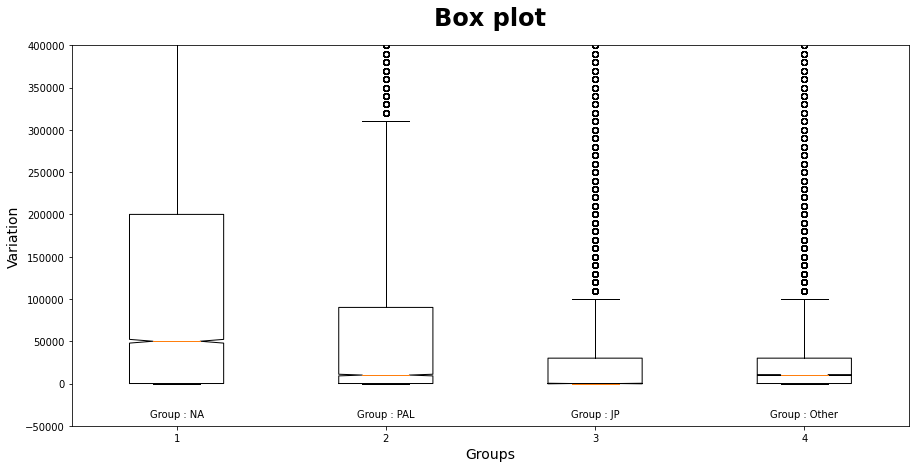

In [1245]:
# box plot을 그리기 위한 그룹 지정
group1 = df.query('region == "NA"')['sales']
group2 = df.query('region == "PAL"')['sales']
group3 = df.query('region == "JP"')['sales']
group4 = df.query('region == "Other"')['sales']

plot_data = [group1, group2, group3, group4]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(15, 7))

ax = plt.boxplot(plot_data, notch=True, whis=2.5)
plt.ylim(-50000, 400000)

plt.title('Box plot', fontsize=24, fontweight = 'bold', pad=20)

plt.xlabel('Groups', fontsize=14)
plt.ylabel('Variation', fontsize=14)

plt.text(1, -40000, 'Group : NA', ha='center')
plt.text(2, -40000, 'Group : PAL', ha='center')
plt.text(3, -40000, 'Group : JP', ha='center')
plt.text(4, -40000, 'Group : Other', ha='center')

medians = [item.get_ydata() for item in ax['medians']]

plt.show()

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_sale_01_boxplot.png'
fig.savefig(path, dpi=150, facecolor='#eeeeee')

In [1246]:
F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4)      # 일원분산분석
posthoc = pairwise_tukeyhsd(df.sales, df.region, alpha=0.05)            # 사후검정 : tukey HSD

results = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])  # 분석결과

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_sale_02_oneway_anova.xlsx'
results.to_excel(path)  # 분석결과 엑셀 저장

print(f"""일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{results}
""")

일원분산분석 결과
F = 617.185, p = 0.000

  group1 group2    meandiff  p-adj       lower       upper  reject
0     JP     NA  163,702.04   0.00  151,366.29  176,037.80    True
1     JP  Other  -25,564.64   0.00  -37,900.39  -13,228.89    True
2     JP    PAL   64,421.57   0.00   52,085.82   76,757.32    True
3     NA  Other -189,266.68   0.00 -201,602.44 -176,930.93    True
4     NA    PAL  -99,280.47   0.00 -111,616.23  -86,944.72    True
5  Other    PAL   89,986.21   0.00   77,650.46  102,321.96    True



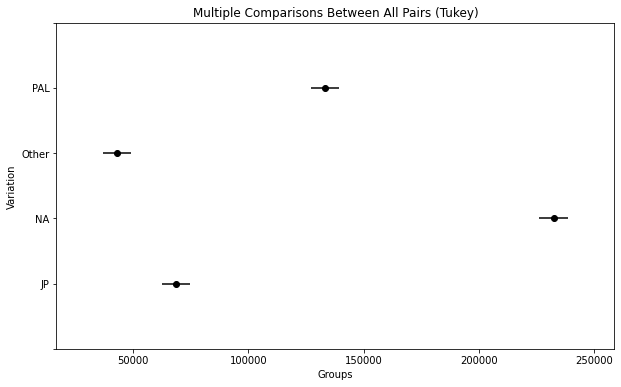

In [1247]:
fig = posthoc.plot_simultaneous() # 사후검정 시각화 그래프

plt.xlabel('Groups')
plt.ylabel('Variation')

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_sale_03_posthoc.png'
fig.savefig(path, dpi=150, facecolor='#eeeeee')

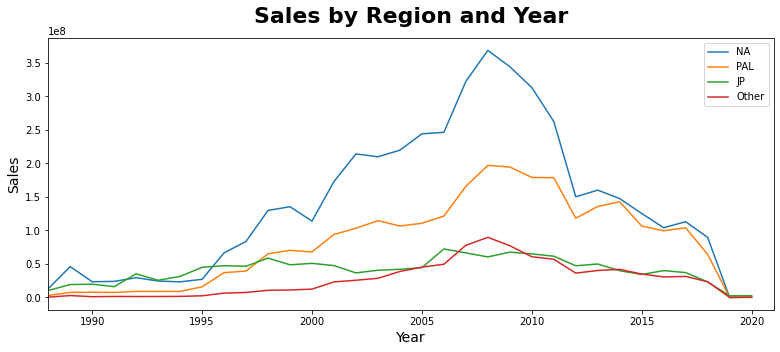

In [1248]:
filt_NA = df.region == "NA"
filt_PAL = df.region == "PAL"
filt_JP = df.region == "JP"
filt_Other = df.region == "Other"
filt_year = df.Year == 9999

## 그래프 그리기
fig, ax = plt.subplots(figsize=(13, 5))

# NA 그래프
x_NA = df[~filt_year][filt_NA].groupby('Year').sum()['sales'].index
y_NA = df[~filt_year][filt_NA].groupby('Year').sum()['sales'].values
ax.plot(x_NA, y_NA, label='NA')

# PAL 그래프
x_PAL = df[~filt_year][filt_PAL].groupby('Year').sum()['sales'].index
y_PAL = df[~filt_year][filt_PAL].groupby('Year').sum()['sales'].values
ax.plot(x_PAL, y_PAL, label='PAL')

# JP 그래프
x_JP = df[~filt_year][filt_JP].groupby('Year').sum()['sales'].index
y_JP = df[~filt_year][filt_JP].groupby('Year').sum()['sales'].values
ax.plot(x_JP, y_JP, label='JP')

# Other 그래프
x_Other = df[~filt_year][filt_Other].groupby('Year').sum()['sales'].index
y_Other = df[~filt_year][filt_Other].groupby('Year').sum()['sales'].values
ax.plot(x_Other, y_Other, label='Other')

## 그래프 설정
plt.title('Sales by Region and Year', fontsize=22, fontweight = 'bold', pad=15)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Sales', fontsize=14)

plt.xlim(1988, 2021)
ax.legend()
plt.show()

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_sale_04_Sales_by_Region_and_Year.png'
fig.savefig(path, dpi=150, facecolor='#eeeeee')

In [1249]:
# 2012년 이후 분산분석
filt_year = (df.Year > 2012) & (df.Year < 3000)
group1 = df[filt_year].query('region == "NA"')['sales']
group2 = df[filt_year].query('region == "PAL"')['sales']
group3 = df[filt_year].query('region == "JP"')['sales']
group4 = df[filt_year].query('region == "Other"')['sales']

F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4)
posthoc = pairwise_tukeyhsd(df[filt_year].sales, df[filt_year].region, alpha=0.05)

posthoc_df = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])
path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_sale_05_posthoc_up2012.xlsx'
posthoc_df.to_excel(path)

print(f"""일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{posthoc_df}
""")

일원분산분석 결과
F = 115.514, p = 0.000

  group1 group2    meandiff  p-adj       lower       upper  reject
0     JP     NA  123,082.67   0.00  100,267.22  145,898.12    True
1     JP  Other   -6,485.90   0.88  -29,301.35   16,329.55   False
2     JP    PAL  102,149.92   0.00   79,334.47  124,965.36    True
3     NA  Other -129,568.57   0.00 -152,384.02 -106,753.12    True
4     NA    PAL  -20,932.75   0.09  -43,748.20    1,882.69   False
5  Other    PAL  108,635.82   0.00   85,820.37  131,451.26    True



### 지역에따라 선호하는 게임의 장르가 있을까?

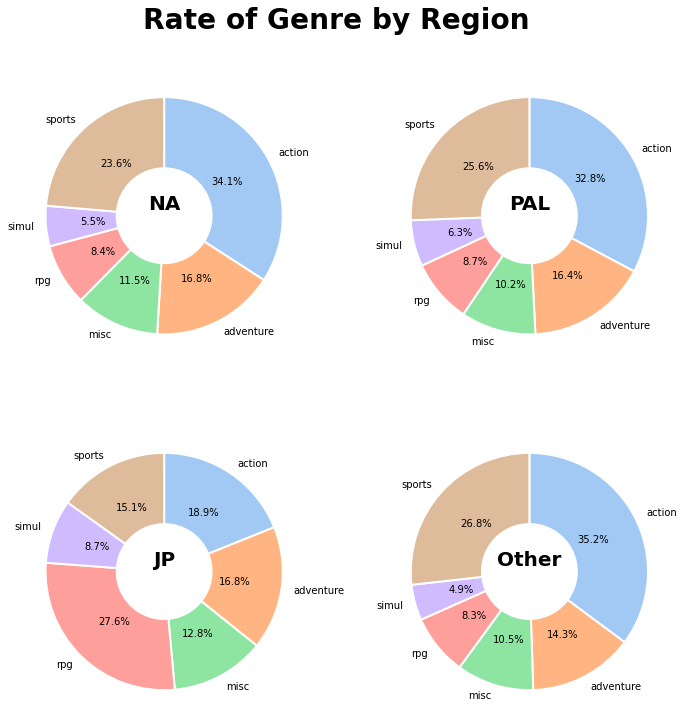

In [1250]:
filt_NA = df.region == "NA"
filt_PAL = df.region == "PAL"
filt_JP = df.region == "JP"
filt_Other = df.region == "Other"

values_NA = df[filt_NA].groupby('gen_6').sum()['sales'].values
labels_NA = df[filt_NA].groupby('gen_6').sum()['sales'].index

values_PAL = df[filt_PAL].groupby('gen_6').sum()['sales'].values
labels_PAL = df[filt_PAL].groupby('gen_6').sum()['sales'].index

values_JP = df[filt_JP].groupby('gen_6').sum()['sales'].values
labels_JP = df[filt_JP].groupby('gen_6').sum()['sales'].index

values_Other = df[filt_Other].groupby('gen_6').sum()['sales'].values
labels_Other = df[filt_Other].groupby('gen_6').sum()['sales'].index

## 그래프 그리기
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

ax[0][0].pie(values_NA, labels=labels_NA,
    autopct='%.1f%%',
    startangle=90,
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)
ax[0][1].pie(values_PAL, labels=labels_PAL, 
    autopct='%.1f%%', 
    startangle=90, 
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)
ax[1][0].pie(values_JP, labels=labels_JP, 
    autopct='%.1f%%', 
    startangle=90, 
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)
ax[1][1].pie(values_Other, labels=labels_Other, 
    autopct='%.1f%%', 
    startangle=90, 
    colors = sns.color_palette('pastel')[0:6],
    wedgeprops={'width':0.6, 'edgecolor':'w', 'linewidth':2},
    counterclock=False)

ax[0][0].set_title('NA', fontsize=20, fontweight = 'bold', y=0.5)
ax[0][1].set_title('PAL', fontsize=20, fontweight = 'bold', y=0.5)
ax[1][0].set_title('JP', fontsize=20, fontweight = 'bold', y=0.5)
ax[1][1].set_title('Other', fontsize=20, fontweight = 'bold', y=0.5)


## 그래프 설정
fig.suptitle('Rate of Genre by Region', fontsize=28, fontweight = 'bold', y=0.95)
# fig.subplots_adjust(top=0.8)

plt.show()


path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_01_region_genre.png'
fig.savefig(path, dpi=150, facecolor='#eeeeee')

In [1251]:
# NA 지역의 비디오게임 장르 분포
region = filt_NA
total_sale = df[region].sum()['sales']
group1 = df[region].query('gen_6 == "action"')['sales']
group2 = df[region].query('gen_6 == "adventure"')['sales']
group3 = df[region].query('gen_6 == "misc"')['sales']
group4 = df[region].query('gen_6 == "rpg"')['sales']
group5 = df[region].query('gen_6 == "sports"')['sales']
group6 = df[region].query('gen_6 == "simul"')['sales']

idx = ['action','adventure','misc','rpg','sports','simul']
data = {
    'Sales' : [group1.sum(), group2.sum(), group3.sum(), group4.sum(), group5.sum(), group6.sum()],
    'Rate' : [group1.sum() / total_sale, group2.sum() / total_sale, group3.sum() / total_sale, group4.sum() / total_sale, group5.sum() / total_sale, group6.sum() / total_sale],
}

summary_table = pd.DataFrame(data, index=idx)

F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4, group5, group6)
posthoc = pairwise_tukeyhsd(df[region].sales, df[region].gen_6, alpha=0.05)

posthoc_df = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])
path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_02_na_genre.xlsx'
posthoc_df.to_excel(path)

print(f"""
{summary_table.sort_values(['Rate'], ascending=False)}

일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{posthoc_df}
""")


                     Sales  Rate
action    1,609,920,000.00  0.34
sports    1,116,100,000.00  0.24
adventure   794,400,000.00  0.17
misc        540,800,000.00  0.11
rpg         398,450,000.00  0.08
simul       259,790,000.00  0.06

일원분산분석 결과
F = 20.347, p = 0.000

       group1     group2    meandiff  p-adj       lower       upper  reject
0      action  adventure  -68,936.12   0.00 -115,191.24  -22,681.00    True
1      action       misc -110,779.66   0.00 -159,640.85  -61,918.48    True
2      action        rpg  -77,577.79   0.00 -135,274.73  -19,880.85    True
3      action      simul -166,496.85   0.00 -221,807.82 -111,185.87    True
4      action     sports  -21,742.39   0.70  -66,043.14   22,558.36   False
5   adventure       misc  -41,843.54   0.22  -95,186.33   11,499.25   False
6   adventure        rpg   -8,641.67   0.90  -70,180.06   52,896.73   False
7   adventure      simul  -97,560.72   0.00 -156,867.90  -38,253.54    True
8   adventure     sports   47,193.73   0.07   -2,0

In [1252]:
# PAL 지역의 비디오게임 장르 분포
region = filt_PAL
total_sale = df[region].sum()['sales']
group1 = df[region].query('gen_6 == "action"')['sales']
group2 = df[region].query('gen_6 == "adventure"')['sales']
group3 = df[region].query('gen_6 == "misc"')['sales']
group4 = df[region].query('gen_6 == "rpg"')['sales']
group5 = df[region].query('gen_6 == "sports"')['sales']
group6 = df[region].query('gen_6 == "simul"')['sales']

idx = ['action','adventure','misc','rpg','sports','simul']
data = {
    'Sales' : [group1.sum(), group2.sum(), group3.sum(), group4.sum(), group5.sum(), group6.sum()],
    'Rate' : [group1.sum() / total_sale, group2.sum() / total_sale, group3.sum() / total_sale, group4.sum() / total_sale, group5.sum() / total_sale, group6.sum() / total_sale],
}

summary_table = pd.DataFrame(data, index=idx)

F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4, group5, group6)
posthoc = pairwise_tukeyhsd(df[region].sales, df[region].gen_6, alpha=0.05)

posthoc_df = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])
path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_03_pal_genre.xlsx'
posthoc_df.to_excel(path)

print(f"""
{summary_table.sort_values(['Rate'], ascending=False)}

일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{posthoc}
""")


                   Sales  Rate
action    886,050,000.00  0.33
sports    692,260,000.00  0.26
adventure 443,830,000.00  0.16
misc      276,080,000.00  0.10
rpg       234,900,000.00  0.09
simul     170,450,000.00  0.06

일원분산분석 결과
F = 16.362, p = 0.000

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
  group1    group2    meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------------
   action adventure -36099.2073 0.0082  -66181.7561  -6016.6586   True
   action      misc -68113.3385  0.001   -99890.775 -36335.9019   True
   action       rpg -34377.9187 0.0944  -71901.7865   3145.9491  False
   action     simul -78578.7809  0.001 -114550.9115 -42606.6503   True
   action    sports   6777.5231    0.9  -22033.9792  35589.0253  False
adventure      misc -32014.1311   0.09  -66706.2291   2677.9668  False
adventure       rpg   1721.2886    0.9  -38300.9157   41743.493  False
adventure     simul -42479.5736 0.0211

In [1253]:
# JP 지역의 비디오게임 장르 분포
region = filt_JP
total_sale = df[region].sum()['sales']
group1 = df[region].query('gen_6 == "action"')['sales']
group2 = df[region].query('gen_6 == "adventure"')['sales']
group3 = df[region].query('gen_6 == "misc"')['sales']
group4 = df[region].query('gen_6 == "rpg"')['sales']
group5 = df[region].query('gen_6 == "sports"')['sales']
group6 = df[region].query('gen_6 == "simul"')['sales']

idx = ['action','adventure','misc','rpg','sports','simul']
data = {
    'Sales' : [group1.sum(), group2.sum(), group3.sum(), group4.sum(), group5.sum(), group6.sum()],
    'Rate' : [group1.sum() / total_sale, group2.sum() / total_sale, group3.sum() / total_sale, group4.sum() / total_sale, group5.sum() / total_sale, group6.sum() / total_sale],
}

summary_table = pd.DataFrame(data, index=idx)

F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4, group5, group6)
posthoc = pairwise_tukeyhsd(df[region].sales, df[region].gen_6, alpha=0.05)

posthoc_df = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])
path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_04_jp_genre.xlsx'
posthoc_df.to_excel(path)

print(f"""
{summary_table.sort_values(['Rate'], ascending=False)}

일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{posthoc}
""")


                   Sales  Rate
rpg       385,330,000.00  0.28
action    263,840,000.00  0.19
adventure 235,010,000.00  0.17
sports    210,890,000.00  0.15
misc      178,920,000.00  0.13
simul     121,500,000.00  0.09

일원분산분석 결과
F = 96.745, p = 0.000

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1    group2    meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------
   action adventure   17867.9243 0.0407      441.871   35293.9776   True
   action      misc   11762.6804 0.4538   -6645.1782    30170.539  False
   action       rpg  157878.1729  0.001  136141.5533  179614.7926   True
   action     simul   10225.5345 0.7012  -10612.2034   31063.2723  False
   action    sports    3160.9144    0.9  -13528.8541   19850.6829  False
adventure      misc   -6105.2439    0.9  -26201.4915   13991.0037  False
adventure       rpg  140010.2487  0.001  116826.4064   163194.091   True
adventure     simu

In [1254]:
# Other 지역의 비디오게임 장르 분포
region = filt_Other
total_sale = df[region].sum()['sales']
group1 = df[region].query('gen_6 == "action"')['sales']
group2 = df[region].query('gen_6 == "adventure"')['sales']
group3 = df[region].query('gen_6 == "misc"')['sales']
group4 = df[region].query('gen_6 == "rpg"')['sales']
group5 = df[region].query('gen_6 == "sports"')['sales']
group6 = df[region].query('gen_6 == "simul"')['sales']

idx = ['action','adventure','misc','rpg','sports','simul']
data = {
    'Sales' : [group1.sum(), group2.sum(), group3.sum(), group4.sum(), group5.sum(), group6.sum()],
    'Rate' : [group1.sum() / total_sale, group2.sum() / total_sale, group3.sum() / total_sale, group4.sum() / total_sale, group5.sum() / total_sale, group6.sum() / total_sale],
}

summary_table = pd.DataFrame(data, index=idx)

F_statistic, pVal = stats.f_oneway(group1, group2, group3, group4, group5, group6)
posthoc = pairwise_tukeyhsd(df[region].sales, df[region].gen_6, alpha=0.05)

posthoc_df = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])
path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_05_other_genre.xlsx'
posthoc_df.to_excel(path)

print(f"""
{summary_table.sort_values(['Rate'], ascending=False)}

일원분산분석 결과
F = {F_statistic:.3f}, p = {pVal:.3f}

{posthoc}
""")


                   Sales  Rate
action    308,170,000.00  0.35
sports    234,730,000.00  0.27
adventure 125,520,000.00  0.14
misc       92,440,000.00  0.11
rpg        72,880,000.00  0.08
simul      42,660,000.00  0.05

일원분산분석 결과
F = 21.997, p = 0.000

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1    group2    meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------------
   action adventure -20581.2491  0.001 -31358.3998  -9804.0985   True
   action      misc -24876.5679  0.001 -36260.9165 -13492.2193   True
   action       rpg -16657.5098 0.0055 -30100.5322  -3214.4875   True
   action     simul -35230.4585  0.001 -48117.5671   -22343.35   True
   action    sports    905.7963    0.9  -9415.9987  11227.5913  False
adventure      misc  -4295.3188    0.9 -16723.8523   8133.2147  False
adventure       rpg   3923.7393    0.9 -10414.3186  18261.7972  False
adventure     simul -14649.2094 0.0303 -28467.40

In [1255]:
# 이원분산분석(two-way ANOVA) : statmodels
formula = 'sales ~ C(region) + C(gen_6) + C(region):C(gen_6)'
lm = ols(formula, df).fit()
results = anova_lm(lm, typ=3)

# posthoc_df = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])
path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_06_twoway_genre_region.xlsx'
results.to_excel(path)

print(results)

                                      sum_sq        df      F  PR(>F)
Intercept              12,538,102,593,658.55      1.00  53.90    0.00
C(region)             214,045,746,271,618.78      3.00 306.69    0.00
C(gen_6)               39,456,825,883,435.78      5.00  33.92    0.00
C(region):C(gen_6)     72,750,054,501,396.91     15.00  20.85    0.00
Residual           18,889,290,854,616,316.00 81,196.00    NaN     NaN


이원분산분석 + 사후검정
[ANOVA + Tukey Test In Python](https://towardsdatascience.com/anova-tukey-test-in-python-b3082b6e6bda)

In [1256]:
df['combination'] = df.region + ' / ' + df.gen_6 # 상호작용항 만들기
posthoc = pairwise_tukeyhsd(df.sales, df.combination, alpha=0.05)

In [1257]:
posthoc_df = pd.DataFrame(data=posthoc._results_table.data[1:], columns=posthoc._results_table.data[0])
posthoc_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,JP / action,JP / adventure,"17,867.92",0.90,"-19,693.88","55,429.73",False
1,JP / action,JP / misc,"11,762.68",0.90,"-27,915.40","51,440.76",False
2,JP / action,JP / rpg,"157,878.17",0.00,"111,024.95","204,731.39",True
3,JP / action,JP / simul,"10,225.53",0.90,"-34,690.15","55,141.22",False
4,JP / action,JP / sports,"3,160.91",0.90,"-32,813.83","39,135.66",False
...,...,...,...,...,...,...,...
271,PAL / misc,PAL / simul,"-10,465.44",0.90,"-60,294.41","39,363.53",False
272,PAL / misc,PAL / sports,"74,890.86",0.00,"32,942.20","116,839.52",True
273,PAL / rpg,PAL / simul,"-44,200.86",0.38,"-99,912.62","11,510.90",False
274,PAL / rpg,PAL / sports,"41,155.44",0.25,"-7,635.58","89,946.47",False


In [1258]:
posthoc_df['group1_reg'] = posthoc_df['group1'].str.split(' / ', n=2, expand=True)[0]
posthoc_df['group1_gen'] = posthoc_df['group1'].str.split(' / ', n=2, expand=True)[1]
posthoc_df['group2_reg'] = posthoc_df['group2'].str.split(' / ', n=2, expand=True)[0]
posthoc_df['group2_gen'] = posthoc_df['group2'].str.split(' / ', n=2, expand=True)[1]

In [1259]:
posthoc_df = posthoc_df[['group1_reg', 'group1_gen', 'group2_reg', 'group2_gen', 'meandiff', 'p-adj', 'lower', 'upper', 'reject']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_07_twoway_posthoc.xlsx'
posthoc_df.to_excel(path)

posthoc_df

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
0,JP,action,JP,adventure,"17,867.92",0.90,"-19,693.88","55,429.73",False
1,JP,action,JP,misc,"11,762.68",0.90,"-27,915.40","51,440.76",False
2,JP,action,JP,rpg,"157,878.17",0.00,"111,024.95","204,731.39",True
3,JP,action,JP,simul,"10,225.53",0.90,"-34,690.15","55,141.22",False
4,JP,action,JP,sports,"3,160.91",0.90,"-32,813.83","39,135.66",False
...,...,...,...,...,...,...,...,...,...
271,PAL,misc,PAL,simul,"-10,465.44",0.90,"-60,294.41","39,363.53",False
272,PAL,misc,PAL,sports,"74,890.86",0.00,"32,942.20","116,839.52",True
273,PAL,rpg,PAL,simul,"-44,200.86",0.38,"-99,912.62","11,510.90",False
274,PAL,rpg,PAL,sports,"41,155.44",0.25,"-7,635.58","89,946.47",False


In [1260]:
posthoc_df.group1_gen.unique()

array(['action', 'adventure', 'misc', 'rpg', 'simul', 'sports'],
      dtype=object)

In [1261]:
filter1 = posthoc_df.group1_gen == "action"
filter2 = posthoc_df.group2_gen == "action"
results = posthoc_df[filter1][filter2]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_08_action.xlsx'
results.to_excel(path)
results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
5,JP,action,NA,action,"242,449.57",0.00,"209,150.28","275,748.85",True
11,JP,action,Other,action,"7,984.51",0.90,"-25,314.77","41,283.79",False
17,JP,action,PAL,action,"112,069.52",0.00,"78,770.24","145,368.81",True
128,NA,action,Other,action,"-234,465.06",0.00,"-267,764.34","-201,165.77",True
134,NA,action,PAL,action,"-130,380.04",0.00,"-163,679.33","-97,080.76",True
215,Other,action,PAL,action,"104,085.01",0.00,"70,785.73","137,384.30",True


In [1262]:
filter1 = posthoc_df.group1_gen == "adventure"
filter2 = posthoc_df.group2_gen == "adventure"
results = posthoc_df[filter1][filter2]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_09_adventure.xlsx'
results.to_excel(path)
results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
28,JP,adventure,NA,adventure,"155,645.52",0.00,"114,257.89","197,033.15",True
34,JP,adventure,Other,adventure,"-30,464.66",0.53,"-71,852.30","10,922.97",False
40,JP,adventure,PAL,adventure,"58,102.39",0.00,"16,714.76","99,490.03",True
145,NA,adventure,Other,adventure,"-186,110.18",0.00,"-227,497.82","-144,722.55",True
151,NA,adventure,PAL,adventure,"-97,543.13",0.00,"-138,930.76","-56,155.49",True
226,Other,adventure,PAL,adventure,"88,567.06",0.00,"47,179.42","129,954.69",True


In [1263]:
filter1 = posthoc_df.group1_gen == "misc"
filter2 = posthoc_df.group2_gen == "misc"
results = posthoc_df[filter1][filter2]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_10_misc.xlsx'
results.to_excel(path)
results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
50,JP,misc,NA,misc,"119,907.22",0.00,"74,742.43","165,072.01",True
56,JP,misc,Other,misc,"-28,654.74",0.78,"-73,819.53","16,510.05",False
62,JP,misc,PAL,misc,"32,193.51",0.59,"-12,971.29","77,358.30",False
161,NA,misc,Other,misc,"-148,561.96",0.00,"-193,726.75","-103,397.17",True
167,NA,misc,PAL,misc,"-87,713.72",0.00,"-132,878.51","-42,548.93",True
236,Other,misc,PAL,misc,"60,848.24",0.00,"15,683.45","106,013.03",True


In [1264]:
filter1 = posthoc_df.group1_gen == "rpg"
filter2 = posthoc_df.group2_gen == "rpg"
results = posthoc_df[filter1][filter2]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_11_rpg.xlsx'
results.to_excel(path)
results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
71,JP,rpg,NA,rpg,"6,993.60",0.90,"-50,291.70","64,278.91",False
77,JP,rpg,Other,rpg,"-166,551.17",0.00,"-223,836.47","-109,265.87",True
83,JP,rpg,PAL,rpg,"-80,186.57",0.00,"-137,471.87","-22,901.27",True
176,NA,rpg,Other,rpg,"-173,544.78",0.00,"-230,830.08","-116,259.47",True
182,NA,rpg,PAL,rpg,"-87,180.17",0.00,"-144,465.47","-29,894.87",True
245,Other,rpg,PAL,rpg,"86,364.61",0.00,"29,079.30","143,649.91",True


In [1265]:
filter1 = posthoc_df.group1_gen == "simul"
filter2 = posthoc_df.group2_gen == "simul"
results = posthoc_df[filter1][filter2]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_12_simul.xlsx'
results.to_excel(path)
results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
91,JP,simul,NA,simul,"65,727.19",0.00,"11,634.72","119,819.65",True
97,JP,simul,Other,simul,"-37,471.48",0.63,"-91,563.95","16,620.98",False
103,JP,simul,PAL,simul,"23,265.21",0.90,"-30,827.25","77,357.67",False
190,NA,simul,Other,simul,"-103,198.67",0.00,"-157,291.13","-49,106.21",True
196,NA,simul,PAL,simul,"-42,461.98",0.40,"-96,554.44","11,630.49",False
253,Other,simul,PAL,simul,"60,736.69",0.01,"6,644.23","114,829.15",True


In [1266]:
filter1 = posthoc_df.group1_gen == "sports"
filter2 = posthoc_df.group2_gen == "sports"
results = posthoc_df[filter1][filter2]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/region_genre_13_sports.xlsx'
results.to_excel(path)
results

,group1_reg,group1_gen,group2_reg,group2_gen,meandiff,p-adj,lower,upper,reject
110,JP,sports,NA,sports,"217,546.26",0.00,"179,081.70","256,010.82",True
116,JP,sports,Other,sports,"5,729.39",0.90,"-32,735.17","44,193.95",False
122,JP,sports,PAL,sports,"115,686.13",0.00,"77,221.57","154,150.69",True
203,NA,sports,Other,sports,"-211,816.87",0.00,"-250,281.43","-173,352.31",True
209,NA,sports,PAL,sports,"-101,860.13",0.00,"-140,324.69","-63,395.57",True
260,Other,sports,PAL,sports,"109,956.74",0.00,"71,492.18","148,421.30",True


### 연도에 따라 비디오 게임의 인기 플랫폼이 다른가?

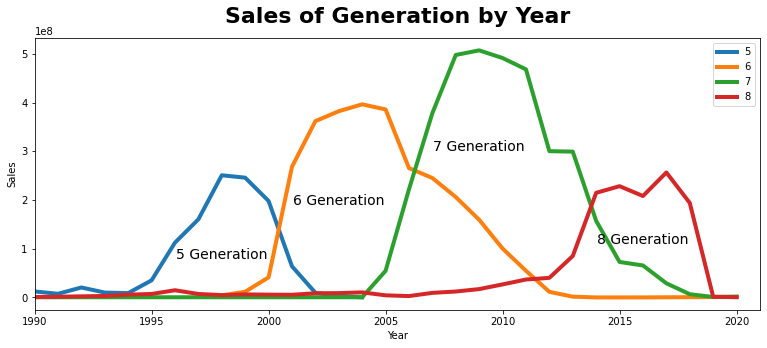

In [1267]:
filt_year = df_total.Year == 9999

## 그래프 그리기
fig, ax = plt.subplots(figsize=(13, 5))

for pf in [5,6,7,8]:
  x = df_total[~filt_year][df_total.pf_gens == pf].groupby('Year').sum()['Total_Sales'].index
  y = df_total[~filt_year][df_total.pf_gens == pf].groupby('Year').sum()['Total_Sales'].values
  ax.plot(x, y, lw=4, label=pf)

plt.text(1998, 10**8*0.8, '5 Generation', ha='center', fontsize=14)
plt.text(2003, 10**8*1.9, '6 Generation', ha='center', fontsize=14)
plt.text(2009, 10**8*3, '7 Generation', ha='center', fontsize=14)
plt.text(2016, 10**8*1.1, '8 Generation', ha='center', fontsize=14)

plt.title('Sales of Generation by Year', fontsize=22, fontweight = 'bold', pad=15)

plt.xlabel('Year')
plt.ylabel('Sales')

plt.xlim(1990, 2021)          

ax.legend()
plt.show()

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/year_platform_01_generation.png'
fig.savefig(path, dpi=150, facecolor='#eeeeee')

In [1268]:
result = df_total.sort_values('Total_Sales', ascending=False).head(10)[['Name','Total_Sales','pf_gens','Genre','Platform','Year']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/year_platform_02_all.xlsx'
result.to_excel(path)

result

,Name,Total_Sales,pf_gens,Genre,Platform,Year
16505,Wii Sports,"82,650,000.00",7,Sports,Wii,2006
8568,Super Mario Bros.,"40,240,000.00",3,Platform,NES,1985
10428,Mario Kart Wii,"35,980,000.00",7,Racing,Wii,2008
16506,Wii Sports Resort,"32,900,000.00",7,Sports,Wii,2009
11924,Pokémon Red / Green / Blue Version,"31,370,000.00",5,Role-Playing,GB,1998
9669,Tetris,"30,260,000.00",5,Puzzle,GB,1989
8569,New Super Mario Bros.,"29,850,000.00",6,Platform,DS,2006
6239,Wii Play,"28,920,000.00",7,Misc,Wii,2007
8570,New Super Mario Bros. Wii,"28,510,000.00",7,Platform,Wii,2009
13724,Duck Hunt,"28,310,000.00",3,Shooter,NES,1985


In [1269]:
filt = df.pf_gens == 5
result = df_total[filt].sort_values('Total_Sales', ascending=False).head()[['Name','Total_Sales','pf_gens','Genre','Platform','Year']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/year_platform_03_5gen.xlsx'
result.to_excel(path)

result

,Name,Total_Sales,pf_gens,Genre,Platform,Year
11924,Pokémon Red / Green / Blue Version,"31,370,000.00",5,Role-Playing,GB,1998
9669,Tetris,"30,260,000.00",5,Puzzle,GB,1989
11925,Pokémon Gold / Silver Version,"23,100,000.00",5,Role-Playing,GB,2000
8574,Super Mario Land,"18,140,000.00",5,Platform,GB,1989
11932,Pokémon Yellow: Special Pikachu Edition,"14,640,000.00",5,Role-Playing,GB,1999


In [1270]:
filt = df.pf_gens == 6
result = df_total[filt].sort_values('Total_Sales', ascending=False).head()[['Name','Total_Sales','pf_gens','Genre','Platform','Year']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/year_platform_04_6gen.xlsx'
result.to_excel(path)

result

,Name,Total_Sales,pf_gens,Genre,Platform,Year
8569,New Super Mario Bros.,"29,850,000.00",6,Platform,DS,2006
15319,Nintendogs,"24,680,000.00",6,Simulation,DS,2005
10429,Mario Kart DS,"23,260,000.00",6,Racing,DS,2005
3,Grand Theft Auto: San Andreas,"20,810,000.00",6,Action,PS2,2004
6240,Brain Age: Train Your Brain in Minutes a Day,"20,160,000.00",6,Misc,DS,2006


In [1271]:
filt = df.pf_gens == 7
result = df_total[filt].sort_values('Total_Sales', ascending=False).head()[['Name','Total_Sales','pf_gens','Genre','Platform','Year']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/year_platform_05_7gen.xlsx'
result.to_excel(path)

result

,Name,Total_Sales,pf_gens,Genre,Platform,Year
16505,Wii Sports,"82,650,000.00",7,Sports,Wii,2006
10428,Mario Kart Wii,"35,980,000.00",7,Racing,Wii,2008
16506,Wii Sports Resort,"32,900,000.00",7,Sports,Wii,2009
6239,Wii Play,"28,920,000.00",7,Misc,Wii,2007
8570,New Super Mario Bros. Wii,"28,510,000.00",7,Platform,Wii,2009


In [1272]:
filt = df.pf_gens == 8
result = df_total[filt].sort_values('Total_Sales', ascending=False).head()[['Name','Total_Sales','pf_gens','Genre','Platform','Year']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/year_platform_06_8gen.xlsx'
result.to_excel(path)

result

,Name,Total_Sales,pf_gens,Genre,Platform,Year
2,Grand Theft Auto V,"19,390,000.00",8,Action,PS4,2014
13725,Call of Duty: Black Ops 3,"15,090,000.00",8,Shooter,PS4,2015
3004,Red Dead Redemption 2,"13,940,000.00",8,Action-Adventure,PS4,2018
13733,Call of Duty: WWII,"13,400,000.00",8,Shooter,PS4,2017
10427,Mario Kart 8 Deluxe,"13,050,000.00",8,Racing,NS,2017


### 인기가 많은 게임은 무엇?

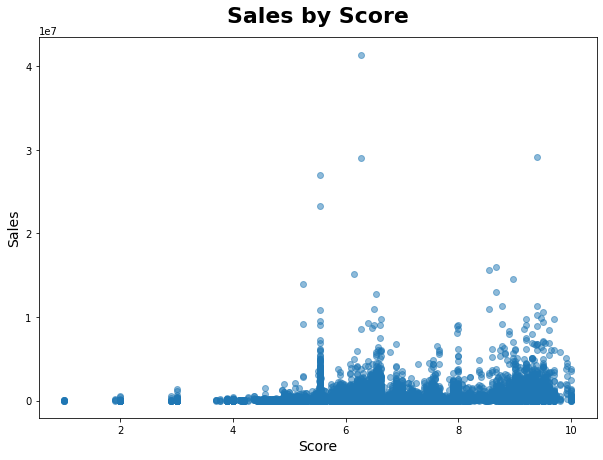

In [1273]:
## 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 7))

plt.scatter(df.Score, df.sales, alpha=0.5)

## 그래프 설정
plt.title('Sales by Score', fontsize=22, fontweight = 'bold', pad=15)


plt.xlabel('Score', fontsize=14)
plt.ylabel('Sales', fontsize=14)

plt.show()

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/pop_game_01_sales_score.png'
fig.savefig(path, dpi=150, facecolor='#eeeeee')

In [1274]:
filt_NA = df.region == "NA"
result = df[filt_NA].sort_values('sales', ascending=False).head()[['Name','Genre','Platform','Year','sales']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/pop_game_02_sales_na.xlsx'
result.to_excel(path)

result

,Name,Genre,Platform,Year,sales
16505,Wii Sports,Sports,Wii,2006,"41,360,000.00"
8568,Super Mario Bros.,Platform,NES,1985,"29,080,000.00"
13724,Duck Hunt,Shooter,NES,1985,"26,930,000.00"
9669,Tetris,Puzzle,GB,1989,"23,200,000.00"
10428,Mario Kart Wii,Racing,Wii,2008,"15,910,000.00"


In [1275]:
filt_PAL = df.region == "PAL"
result = df[filt_PAL].sort_values('sales', ascending=False).head()[['Name','Genre','Platform','Year','sales']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/pop_game_03_sales_pal.xlsx'
result.to_excel(path)

result

,Name,Genre,Platform,Year,sales
36810,Wii Sports,Sports,Wii,2006,"29,020,000.00"
30733,Mario Kart Wii,Racing,Wii,2008,"12,920,000.00"
36811,Wii Sports Resort,Sports,Wii,2009,"10,990,000.00"
35624,Nintendogs,Simulation,DS,2005,"10,960,000.00"
20305,Grand Theft Auto V,Action,PS3,2013,"9,850,000.00"


In [1276]:
filt_JP = df.region == "JP"
result = df[filt_JP].sort_values('sales', ascending=False).head()[['Name','Genre','Platform','Year','sales']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/pop_game_04_sales_jp.xlsx'
result.to_excel(path)

result

,Name,Genre,Platform,Year,sales
52534,Pokémon Red / Green / Blue Version,Role-Playing,GB,1998,"10,220,000.00"
52535,Pokémon Gold / Silver Version,Role-Playing,GB,2000,"7,200,000.00"
49178,Super Mario Bros.,Platform,NES,1985,"6,810,000.00"
49179,New Super Mario Bros.,Platform,DS,2006,"6,500,000.00"
52536,Pokémon Diamond / Pearl Version,Role-Playing,DS,2007,"6,040,000.00"


In [1277]:
filt_Other = df.region == "Other"
result = df[filt_Other].sort_values('sales', ascending=False).head()[['Name','Genre','Platform','Year','sales']]

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/pop_game_05_sales_other.xlsx'
result.to_excel(path)

result

,Name,Genre,Platform,Year,sales
60918,Grand Theft Auto: San Andreas,Action,PS2,2004,"10,570,000.00"
77420,Wii Sports,Sports,Wii,2006,"8,510,000.00"
71348,Gran Turismo 4,Racing,PS2,2005,"7,530,000.00"
71343,Mario Kart Wii,Racing,Wii,2008,"3,350,000.00"
60915,Grand Theft Auto V,Action,PS3,2013,"3,120,000.00"


# 미디어패널 조사

In [1278]:
for i in range(10,22):
  mp_path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/data/media_panel/h{}v28_KMP_csv.csv'.format(i)
  mp_raw = pd.read_csv(mp_path, encoding='cp949')
  print(i, ' : ', mp_raw.shape)
  globals()['mp_h{}_raw'.format(i)] = mp_raw

10  :  (3085, 865)
11  :  (4539, 827)
12  :  (4414, 853)
13  :  (4381, 908)
14  :  (4313, 940)
15  :  (4305, 961)
16  :  (4233, 951)
17  :  (4203, 1007)
18  :  (4162, 1056)
19  :  (4583, 930)
20  :  (4260, 816)
21  :  (4171, 879)


In [1279]:
for i in globals():
  if i[0:4] == 'mp_h' and i[-4:] == '_raw':
    filt = globals()[i].columns.str.contains('a09001')
    print(i, ' 카운트 : ', globals()[i].iloc[:,np.where(filt)[0]].value_counts())
    print(i, ' 결측치 : ', globals()[i].iloc[:,np.where(filt)[0]].isna().sum())

mp_h10_raw  카운트 :  h10a09001
2            2486
1             599
dtype: int64
mp_h10_raw  결측치 :  h10a09001    0
dtype: int64
mp_h11_raw  카운트 :  h11a09001
2            3898
1             641
dtype: int64
mp_h11_raw  결측치 :  h11a09001    0
dtype: int64
mp_h12_raw  카운트 :  h12a09001
2            2968
2             874
1             422
1             149
                1
dtype: int64
mp_h12_raw  결측치 :  h12a09001    0
dtype: int64
mp_h13_raw  카운트 :  h13a09001
2            3933
1             448
dtype: int64
mp_h13_raw  결측치 :  h13a09001    0
dtype: int64
mp_h14_raw  카운트 :  h14a09001
2            3984
1             329
dtype: int64
mp_h14_raw  결측치 :  h14a09001    0
dtype: int64
mp_h15_raw  카운트 :  h15a09001
2            4013
1             292
dtype: int64
mp_h15_raw  결측치 :  h15a09001    0
dtype: int64
mp_h16_raw  카운트 :  h16a09001
2            4021
1             212
dtype: int64
mp_h16_raw  결측치 :  h16a09001    0
dtype: int64
mp_h17_raw  카운트 :  h17a09001
2            4013
1             190
dtype:

In [1280]:
mp_h12_raw.h12a09001.unique()

array([1, 2, '2', '1', ' '], dtype=object)

In [1281]:
filt = mp_h12_raw.h12a09001 == ' '
mp_h12_raw.drop(index=mp_h12_raw[filt].index, inplace=True)
mp_h12_raw.h12a09001.unique()

array([1, 2, '2', '1'], dtype=object)

In [1282]:
mp_h12_raw.h12a09001 = mp_h12_raw.h12a09001.astype(int)

In [1283]:
for i in globals():
  if i[0:4] == 'mp_h' and i[-4:] == '_raw':
    filt = globals()[i].columns.str.contains('a09001')
    print(i, ' 카운트 : ', globals()[i].iloc[:,np.where(filt)[0]].value_counts())
    print(i, ' 결측치 : ', globals()[i].iloc[:,np.where(filt)[0]].isna().sum())

mp_h10_raw  카운트 :  h10a09001
2            2486
1             599
dtype: int64
mp_h10_raw  결측치 :  h10a09001    0
dtype: int64
mp_h11_raw  카운트 :  h11a09001
2            3898
1             641
dtype: int64
mp_h11_raw  결측치 :  h11a09001    0
dtype: int64
mp_h12_raw  카운트 :  h12a09001
2            3842
1             571
dtype: int64
mp_h12_raw  결측치 :  h12a09001    0
dtype: int64
mp_h13_raw  카운트 :  h13a09001
2            3933
1             448
dtype: int64
mp_h13_raw  결측치 :  h13a09001    0
dtype: int64
mp_h14_raw  카운트 :  h14a09001
2            3984
1             329
dtype: int64
mp_h14_raw  결측치 :  h14a09001    0
dtype: int64
mp_h15_raw  카운트 :  h15a09001
2            4013
1             292
dtype: int64
mp_h15_raw  결측치 :  h15a09001    0
dtype: int64
mp_h16_raw  카운트 :  h16a09001
2            4021
1             212
dtype: int64
mp_h16_raw  결측치 :  h16a09001    0
dtype: int64
mp_h17_raw  카운트 :  h17a09001
2            4013
1             190
dtype: int64
mp_h17_raw  결측치 :  h17a09001    0
dtype: int64


In [1284]:
for i in globals():
  if i[0:4] == 'mp_h' and i[-4:] == '_raw':
    filt = globals()[i].columns.str.contains('a09001')
    print(i, globals()[i].iloc[:,np.where(filt)[0]].value_counts(normalize=True)[1])

mp_h10_raw 0.19416531604538087
mp_h11_raw 0.14122053315708305
mp_h12_raw 0.1293904373442103
mp_h13_raw 0.10225975804610819
mp_h14_raw 0.07628101089728727
mp_h15_raw 0.0678281068524971
mp_h16_raw 0.050082683675879994
mp_h17_raw 0.04520580537711159
mp_h18_raw 0.0422873618452667
mp_h19_raw 0.05062186340824787
mp_h20_raw 0.05352112676056338
mp_h21_raw 0.05082713977463438


In [1285]:
merge_mp = mp_h10_raw.hid

merge_mp = pd.merge(left = merge_mp, right = mp_h10_raw[['hid','h10a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h11_raw[['hid','h11a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h12_raw[['hid','h12a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h13_raw[['hid','h13a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h14_raw[['hid','h14a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h15_raw[['hid','h15a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h16_raw[['hid','h16a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h17_raw[['hid','h17a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h18_raw[['hid','h18a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h19_raw[['hid','h19a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h20_raw[['hid','h20a09001']], how = 'outer', on = 'hid')
merge_mp = pd.merge(left = merge_mp, right = mp_h21_raw[['hid','h21a09001']], how = 'outer', on = 'hid')

merge_mp

,hid,h10a09001,h11a09001,h12a09001,h13a09001,h14a09001,h15a09001,h16a09001,h17a09001,h18a09001,h19a09001,h20a09001,h21a09001
0,100.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00
1,800.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
2,900.00,2.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,2.00,NaN
3,"1,100.00",2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,NaN,NaN,NaN
4,"1,300.00",2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,694101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00
8476,1046701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00
8477,1046901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00
8478,1048601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00


In [1286]:
merge_mp.columns

Index(['hid', 'h10a09001', 'h11a09001', 'h12a09001', 'h13a09001', 'h14a09001',
       'h15a09001', 'h16a09001', 'h17a09001', 'h18a09001', 'h19a09001',
       'h20a09001', 'h21a09001'],
      dtype='object')

In [1287]:
merge_mp.rename(columns={
                        'h10a09001' : '2010',
                        'h11a09001' : '2011',
                        'h12a09001' : '2012',
                        'h13a09001' : '2013',
                        'h14a09001' : '2014',
                        'h15a09001' : '2015',
                        'h16a09001' : '2016',
                        'h17a09001' : '2017',
                        'h18a09001' : '2018',
                        'h19a09001' : '2019',
                        'h20a09001' : '2020',
                        'h21a09001' : '2021'
                        }, inplace=True)
merge_mp.columns

Index(['hid', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021'],
      dtype='object')

In [1288]:
merge_mp.columns[1:]

Index(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021'],
      dtype='object')

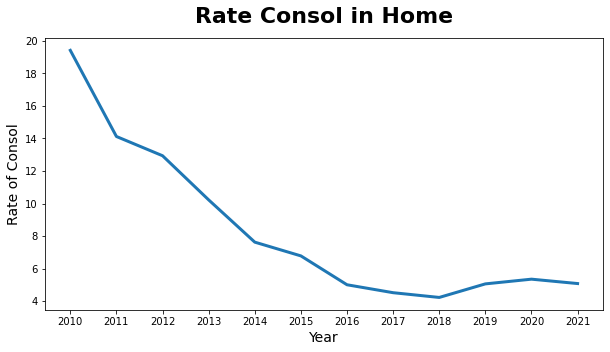

In [1289]:
fig, ax = plt.subplots(figsize=(10, 5))

consol_rate = []

for year in merge_mp.columns[1:]:
  consol_rate.append(merge_mp[year].value_counts(normalize=True)[1]*100)

ax.plot(merge_mp.columns[1:], consol_rate, lw=3)


## 그래프 설정
plt.title('Rate Consol in Home', fontsize=22, fontweight = 'bold', pad=15)


plt.xlabel('Year', fontsize=14)
plt.ylabel('Rate of Consol', fontsize=14)

plt.show()

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/mediapanel_01_rate_consol.png'
fig.savefig(path, dpi=150, facecolor='#eeeeee')

In [1290]:
for i in range(17,22):
  mp_path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/data/media_panel/p{}v28_KMP_csv.csv'.format(i)
  mp_raw = pd.read_csv(mp_path, encoding='cp949')
  print(i, ' : ', mp_raw.shape)
  globals()['mp_p{}_raw'.format(i)] = mp_raw

17  :  (9425, 433)
18  :  (9426, 423)
19  :  (10864, 432)
20  :  (10302, 487)
21  :  (10154, 511)


In [1291]:
for i in globals():
  if i[0:4] == 'mp_p' and i[-4:] == '_raw':
    filt = globals()[i].columns.str.contains('c05043')
    print(i, ' 카운트 : ', globals()[i].iloc[:,np.where(filt)[0]].value_counts())
    print(i, ' 결측치 : ', globals()[i].iloc[:,np.where(filt)[0]].isna().sum())

mp_p17_raw  카운트 :  p17c05043
             9061
1             299
3              55
2               6
4               4
dtype: int64
mp_p17_raw  결측치 :  p17c05043    0
dtype: int64
mp_p18_raw  카운트 :  p18c05043
             7974
1            1275
3             161
2               9
4               7
dtype: int64
mp_p18_raw  결측치 :  p18c05043    0
dtype: int64
mp_p19_raw  카운트 :  p19c05043
             9314
1            1385
3             135
4              16
2              14
dtype: int64
mp_p19_raw  결측치 :  p19c05043    0
dtype: int64
mp_p20_raw  카운트 :  p20c05043
             8314
1            1780
3             182
2              21
4               5
dtype: int64
mp_p20_raw  결측치 :  p20c05043    0
dtype: int64
mp_p21_raw  카운트 :  p21c05043
             7512
1            2350
3             250
2              29
4              13
dtype: int64
mp_p21_raw  결측치 :  p21c05043    0
dtype: int64


In [1292]:
mp_p = mp_p17_raw.pid

mp_p = pd.merge(left = mp_p, right = mp_p17_raw[['pid','p17c05043']], how = 'outer', on = 'pid')
mp_p = pd.merge(left = mp_p, right = mp_p18_raw[['pid','p18c05043']], how = 'outer', on = 'pid')
mp_p = pd.merge(left = mp_p, right = mp_p19_raw[['pid','p19c05043']], how = 'outer', on = 'pid')
mp_p = pd.merge(left = mp_p, right = mp_p20_raw[['pid','p20c05043']], how = 'outer', on = 'pid')
mp_p = pd.merge(left = mp_p, right = mp_p21_raw[['pid','p21c05043']], how = 'outer', on = 'pid')

mp_p

,pid,p17c05043,p18c05043,p19c05043,p20c05043,p21c05043
0,10001,,,,1,1
1,10002,,1,,1,1
2,20001,,,,,
3,30001,,,,,
4,30002,,,,,
...,...,...,...,...,...,...
13012,117880004,NaN,NaN,NaN,NaN,1
13013,117910002,NaN,NaN,NaN,NaN,
13014,117940003,NaN,NaN,NaN,NaN,
13015,118140005,NaN,NaN,NaN,NaN,1


In [1293]:
mp_p.rename(columns={
                    'p17c05043' : '2017',
                    'p18c05043' : '2018',
                    'p19c05043' : '2019',
                    'p20c05043' : '2020',
                    'p21c05043' : '2021'
                    }, inplace=True)
mp_p.columns

Index(['pid', '2017', '2018', '2019', '2020', '2021'], dtype='object')

In [1294]:
mp_p['2017'].value_counts(normalize=True).sort_index()['1']

0.031724137931034485

In [1295]:
mp_p['2017'].value_counts(normalize=True).sort_index()

    0.96
1   0.03
2   0.00
3   0.01
4   0.00
Name: 2017, dtype: float64

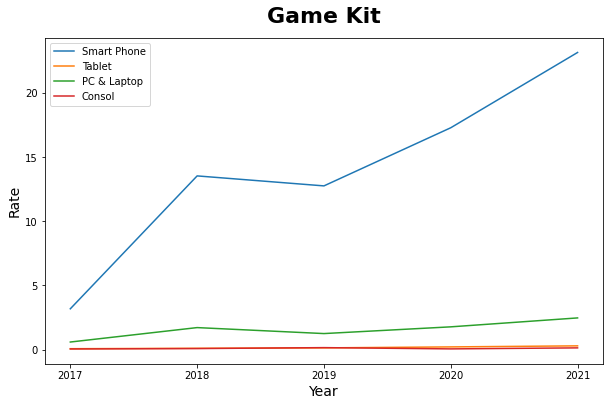

In [1296]:
fig, ax1 = plt.subplots(figsize=(10, 6))

smart_phone = []
tablet = []
PC_laptop = []
consol = []

for year in mp_p.columns[1:]:
  smart_phone.append(mp_p[year].value_counts(normalize=True).sort_index()['1']*100)
  tablet.append(mp_p[year].value_counts(normalize=True).sort_index()['2']*100)
  PC_laptop.append(mp_p[year].value_counts(normalize=True).sort_index()['3']*100)
  consol.append(mp_p[year].value_counts(normalize=True).sort_index()['4']*100)

ax1.plot(mp_p.columns[1:], smart_phone, label='Smart Phone')
ax1.plot(mp_p.columns[1:], tablet, label='Tablet')
ax1.plot(mp_p.columns[1:], PC_laptop, label='PC & Laptop')
ax1.plot(mp_p.columns[1:], consol, label='Consol')

## 그래프 설정
plt.title('Game Kit', fontsize=22, fontweight = 'bold', pad=15)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Rate', fontsize=14)

ax1.legend()
plt.show()

path = '/content/drive/Shareddrives/coding/aib/AIB_section1_project/results/mediapanel_02_game_kit.png'
fig.savefig(path, dpi=150, facecolor='#eeeeee')